# 뉴욕 택시 수요예측

## 데이터 시각화(1)
### NYC 뉴욕 택시 데이터 EDA
- 시간대 별 콜 수는?
- 요일별 콜 수는?

In [7]:
import chart_studio.plotly as py
import cufflinks as cf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
print(cf.__version__)

%config InlineBackend.figure_format ='retina'
cf.go_offline()

0.17.3


### 1월의 전체 Trip 수

In [12]:
%%time
query = """
SELECT
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    count(*) as cnt
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
WHERE EXTRACT(MONTH from pickup_datetime) = 1
GROUP BY pickup_hour
ORDER BY pickup_hour
"""

df = pd.read_gbq(query=query, dialect='standard', project_id='predictfornyctaxi', auth_local_webserver=True)

CPU times: user 135 ms, sys: 19.4 ms, total: 154 ms
Wall time: 5.16 s


In [13]:
df.tail(10)

pickup_hour    cnt
734 2015-01-31 14:00:00  25059
735 2015-01-31 15:00:00  25886
736 2015-01-31 16:00:00  23822
737 2015-01-31 17:00:00  25794
738 2015-01-31 18:00:00  30804
739 2015-01-31 19:00:00  32436
740 2015-01-31 20:00:00  27555
741 2015-01-31 21:00:00  27477
742 2015-01-31 22:00:00  29862
743 2015-01-31 23:00:00  29856

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   pickup_hour  744 non-null    datetime64[ns]
 1   cnt          744 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.8 KB


In [15]:
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'])

In [16]:
df.head()

pickup_hour    cnt
0 2015-01-01 00:00:00  28312
1 2015-01-01 01:00:00  31707
2 2015-01-01 02:00:00  28068
3 2015-01-01 03:00:00  24288
4 2015-01-01 04:00:00  17081

In [17]:
df = df.set_index('pickup_hour')

In [18]:
df.head()

cnt
pickup_hour               
2015-01-01 00:00:00  28312
2015-01-01 01:00:00  31707
2015-01-01 02:00:00  28068
2015-01-01 03:00:00  24288
2015-01-01 04:00:00  17081

In [22]:
df.iplot(kind='scatter', xTitle='Datetimes', yTitle='Demand', title='NYC Taxi Demane(2015-01)')

- Jan 27, 2015 02:00에 급격히 하락한 건수
    - 2015년 1월 23일에 큰 눈폭풍이 발생해 26.8인치 만큼의 눈이 옴
    - 전체 택시 trip 횟수가 크게 감소

### Date 별 Trip 수

In [23]:
df['date'] = df.index.date

In [24]:
df.groupby(['date'])[['cnt']].sum().iplot()

### 요일별 시간대별 Trip 수

In [25]:
df.head(2)

cnt        date
pickup_hour                           
2015-01-01 00:00:00  28312  2015-01-01
2015-01-01 01:00:00  31707  2015-01-01

In [26]:
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour
df['weeknum'] = df.index.week

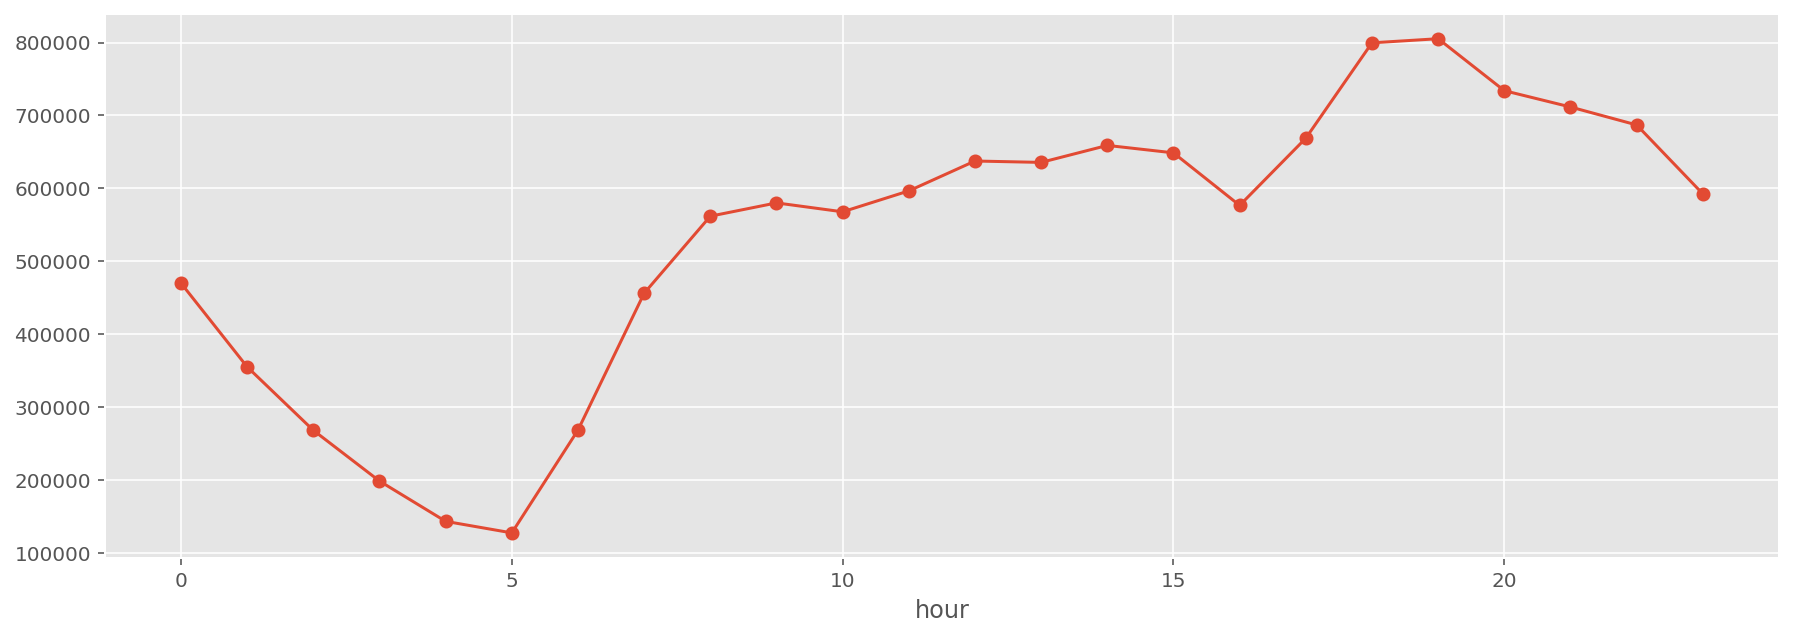

In [27]:
df.groupby('hour')['cnt'].sum().plot(x='hour', y=['cnt'], kind='line', style='-o', figsize=(15, 5));

- 피크 시간대는 18~19시이며, 5시에 최저피크를 보인다.

In [28]:
df.groupby(['hour', 'weekday'])['cnt'].mean().unstack().iplot()

- pivot table로 작성해보기

In [29]:
df[['cnt', 'hour', 'weekday']].pivot_table('cnt', index='hour', columns='weekday', aggfunc='mean').iplot(kind='scatter')

- weekday 별 trip 수

In [30]:
df.groupby('weekday')[['cnt']].mean().iplot(kind='bar')

### 평일 / 주말별 Trip 수

In [31]:
df['is_weekend'] = ((pd.DatetimeIndex(df.index).dayofweek) // 5 == 1).astype(int)

In [32]:
df.groupby(['hour', 'is_weekend'])['cnt'].mean().unstack().iplot()

- 평일과 주말 사이에 약간 차이를 보이며 주말에는 새벽 콜이 평일보다 많다.

### 요일별 시간대별 히트맵

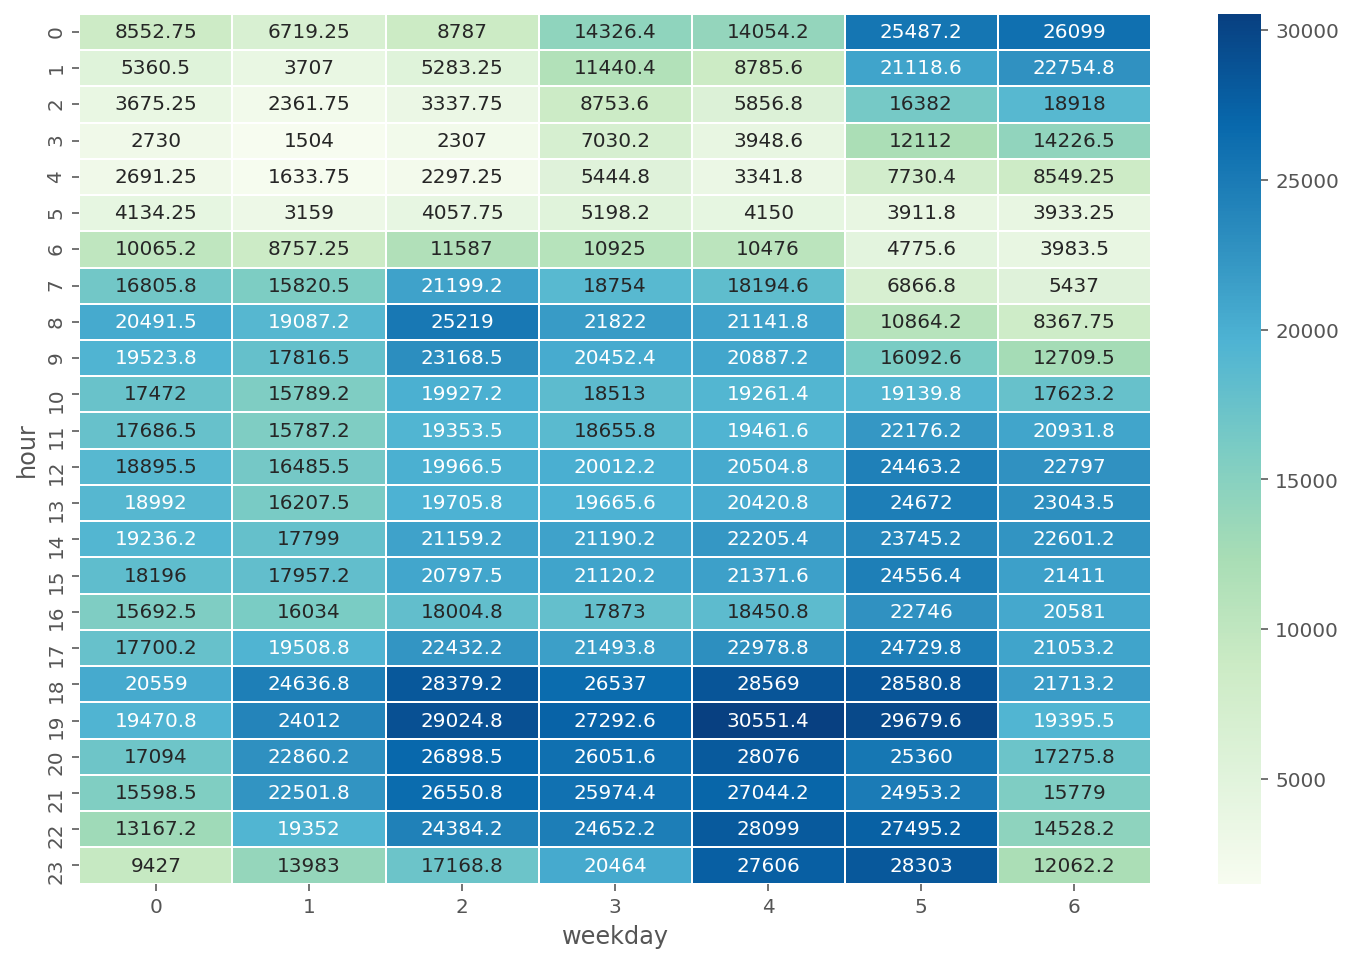

In [34]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.groupby(['hour', 'weekday'])['cnt'].mean().unstack(),
           lw=.5, annot=True, cmap='GnBu', fmt='g', annot_kws={'size':10});

- 금요일 오후부터 Call이 상승

In [35]:
average_df = df.groupby(['is_weekend', 'hour']).mean()['cnt'].unstack(level=0).rename(columns={0:'weekday', 1:'weekend'})

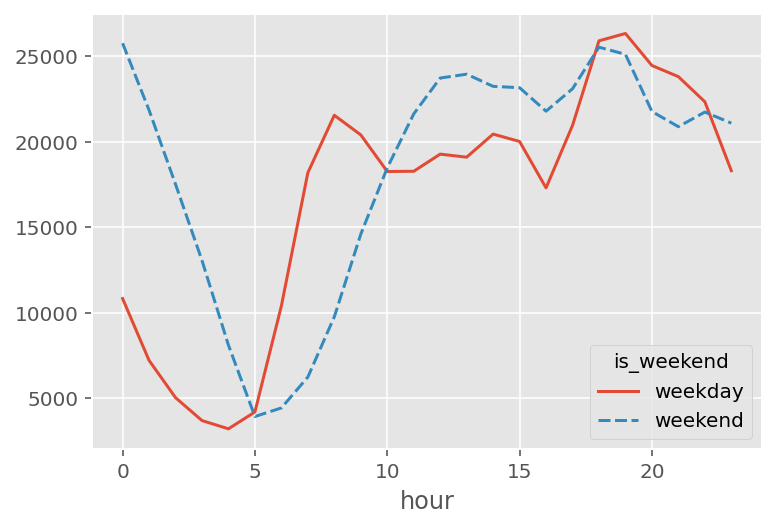

In [36]:
sns.lineplot(data=average_df);

In [37]:
df.head(3)

cnt        date  weekday  hour  weeknum  is_weekend
pickup_hour                                                               
2015-01-01 00:00:00  28312  2015-01-01        3     0        1           0
2015-01-01 01:00:00  31707  2015-01-01        3     1        1           0
2015-01-01 02:00:00  28068  2015-01-01        3     2        1           0

In [40]:
data = df.groupby(['weekday','hour']).mean()['cnt'].unstack(level=0).reset_index()
data = data.melt(id_vars='hour', value_vars=[0,1,2,3,4,5,6], value_name='cnt')

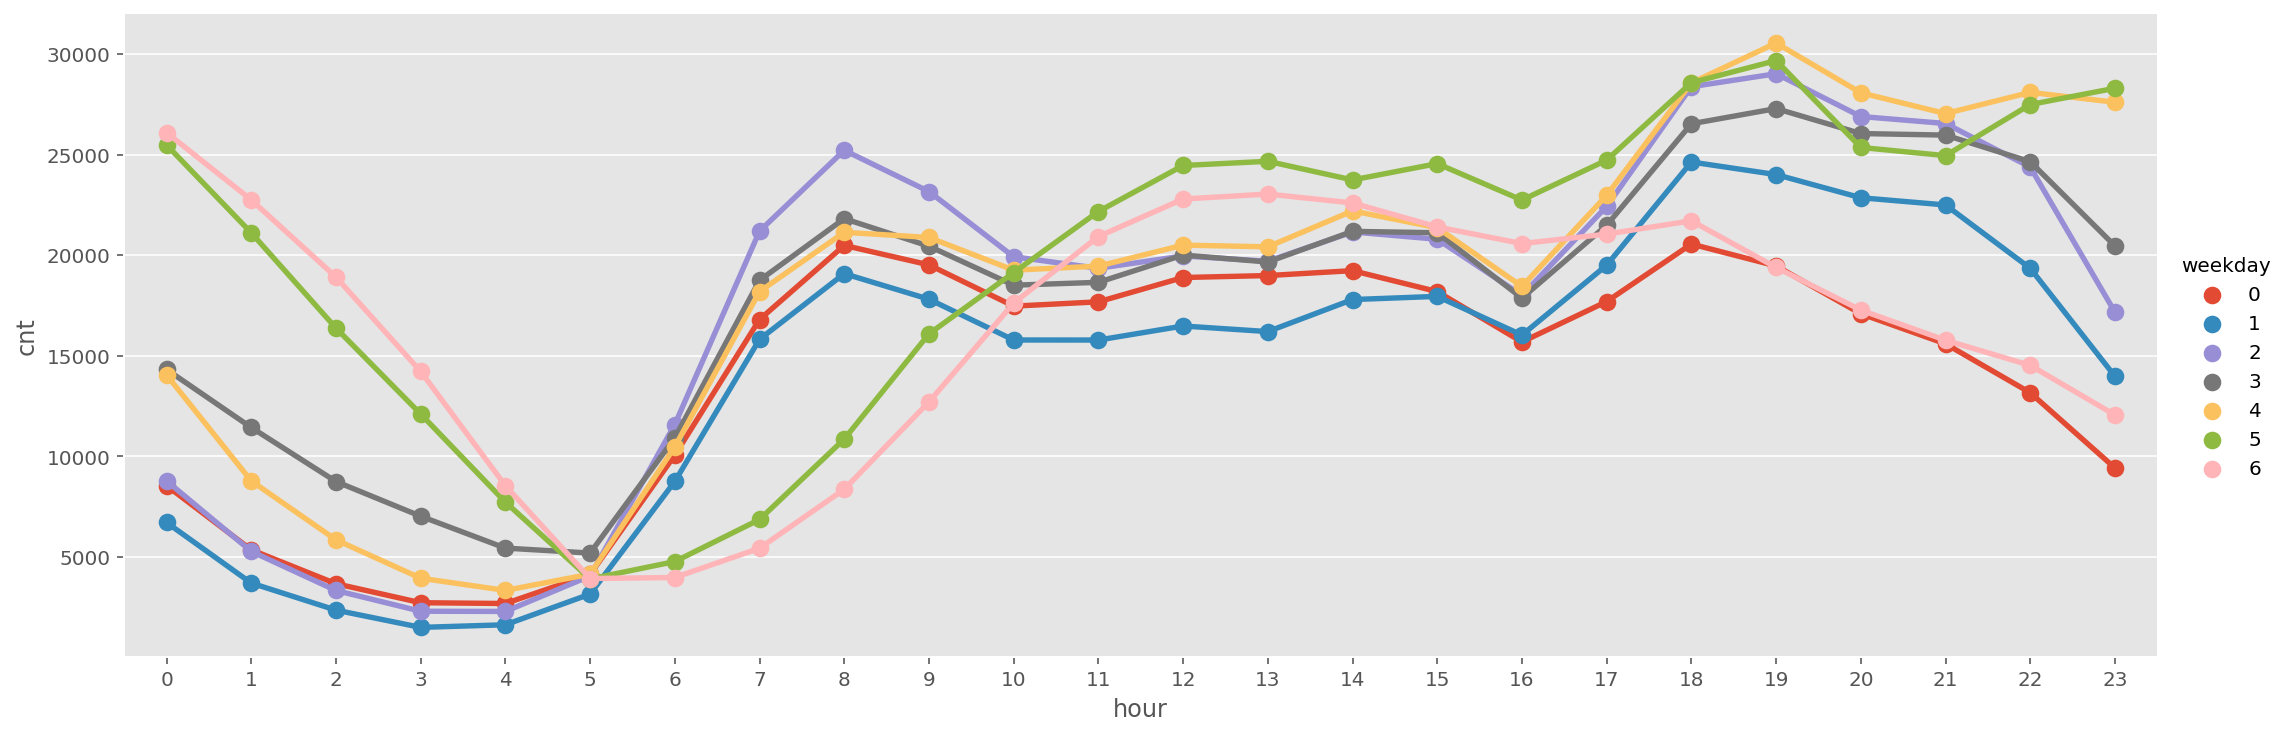

In [41]:
sns.factorplot(x='hour', y='cnt', hue='weekday', data=data, height=5, aspect=3);

 ### BoxPlot

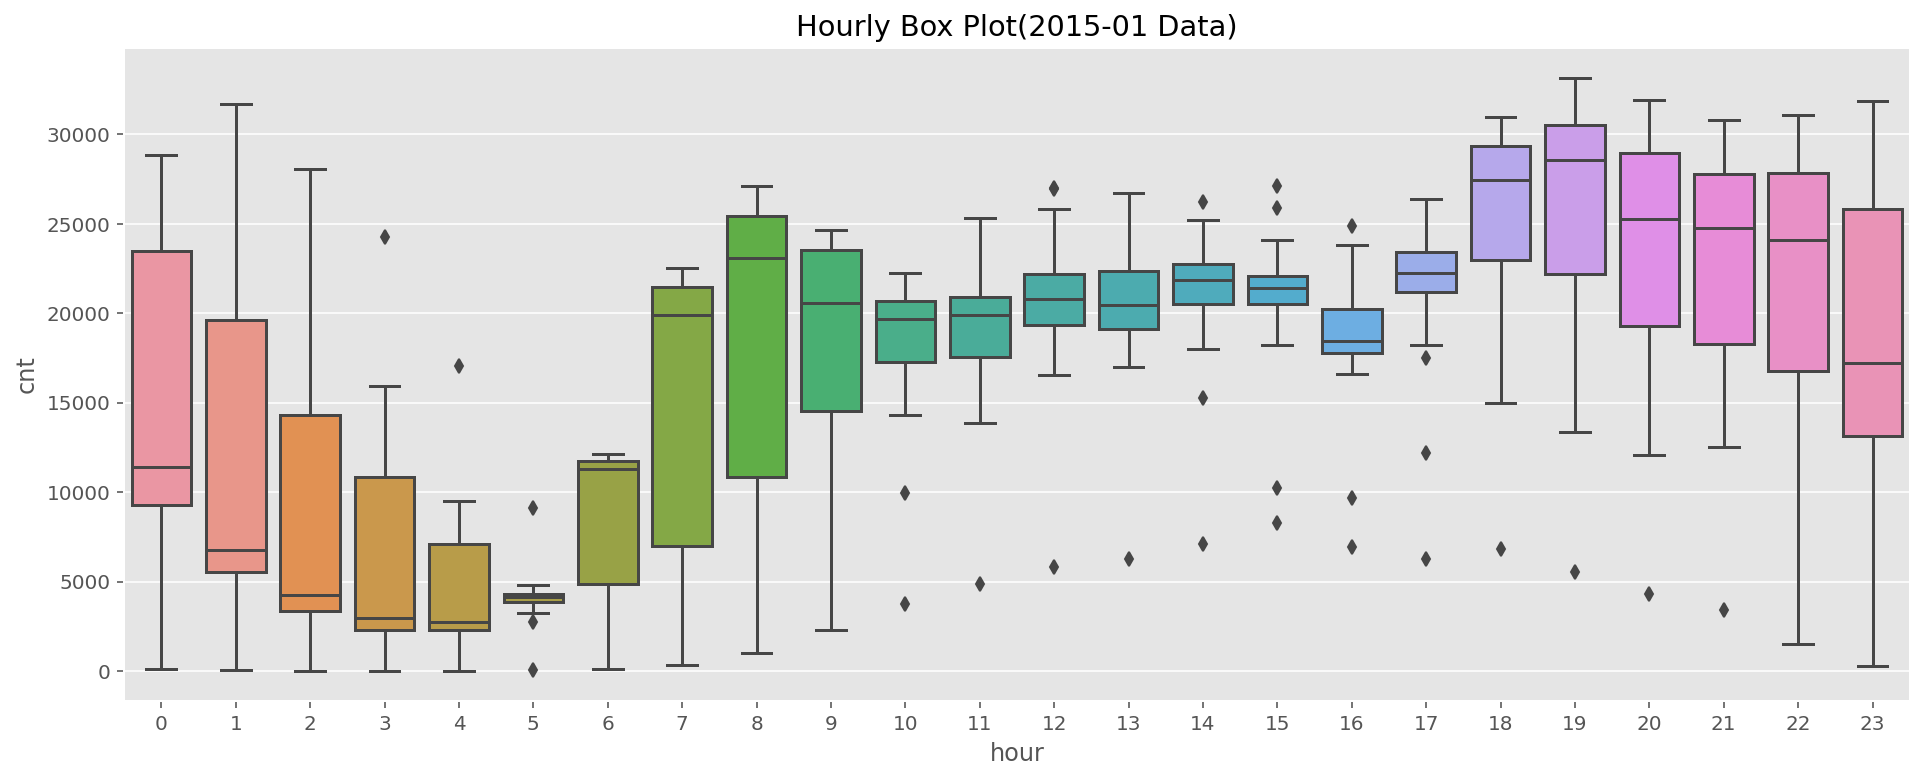

In [42]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='hour', y='cnt', data=df)
plt.title('Hourly Box Plot(2015-01 Data)');

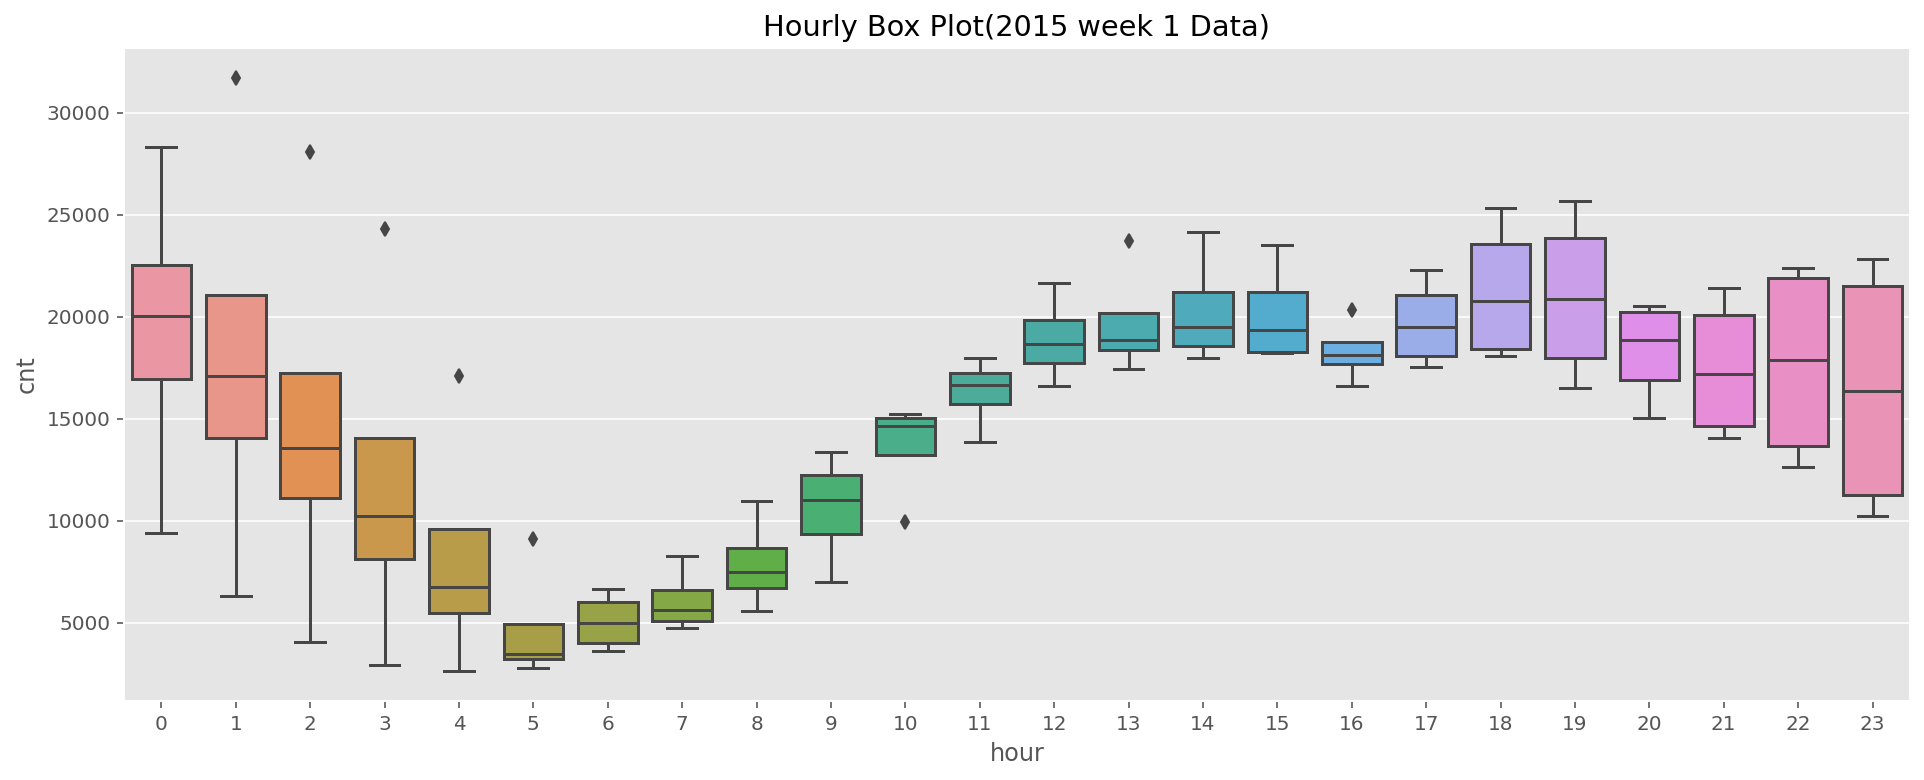

In [43]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='hour', y='cnt', data=df[df['weeknum']==1]);
plt.title('Hourly Box Plot(2015 week 1 Data)');

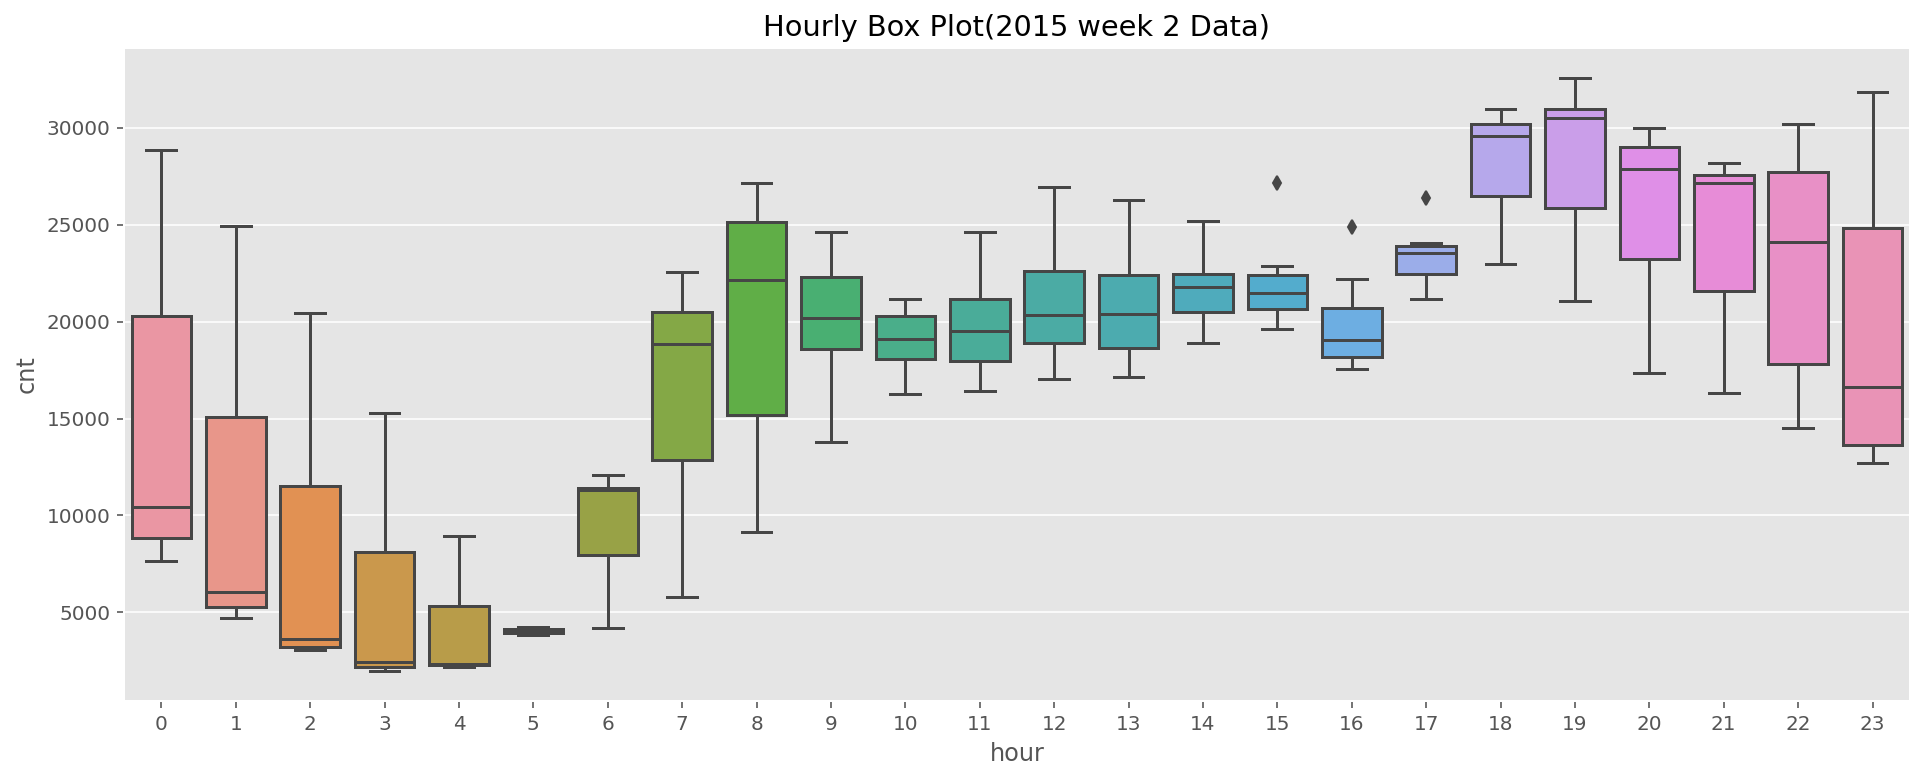

In [44]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='hour', y='cnt', data=df[df['weeknum']==2]);
plt.title('Hourly Box Plot(2015 week 2 Data)');

In [45]:
def visualize_hourly_boxplot_by_weeknum(df, y, weeknum):
    plt.figure(figsize=(16, 6));
    sns.boxplot(x='hour', y='cnt', data=df[df['weeknum']==weeknum]);
    plt.title(f'Hourly Box Plot(2015 - {weeknum:02} Data)');

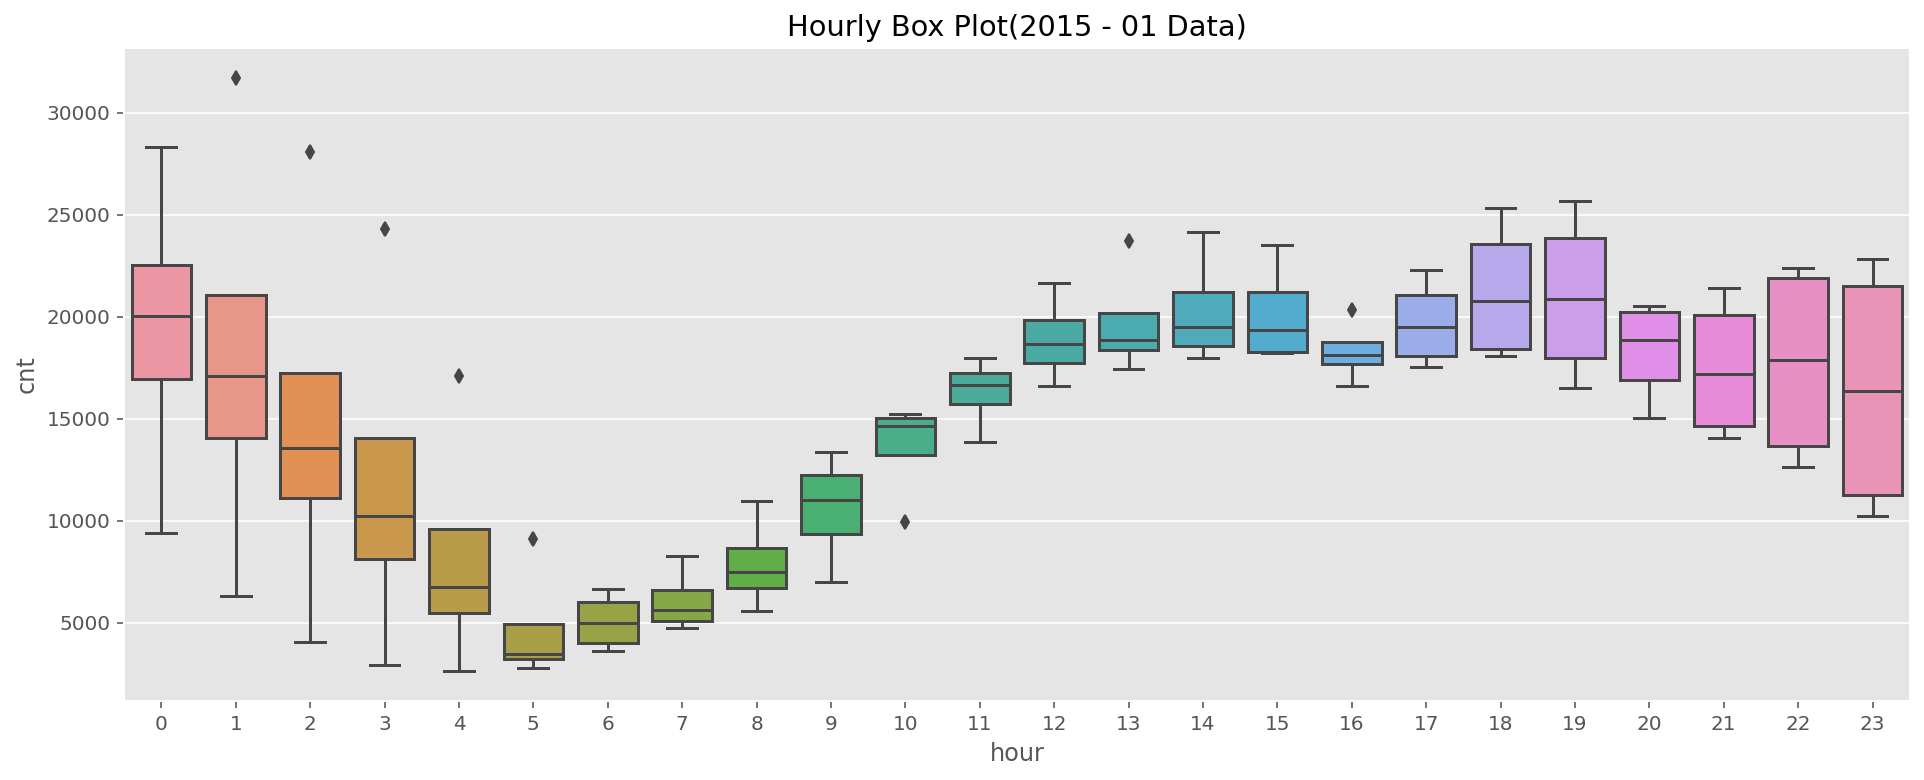

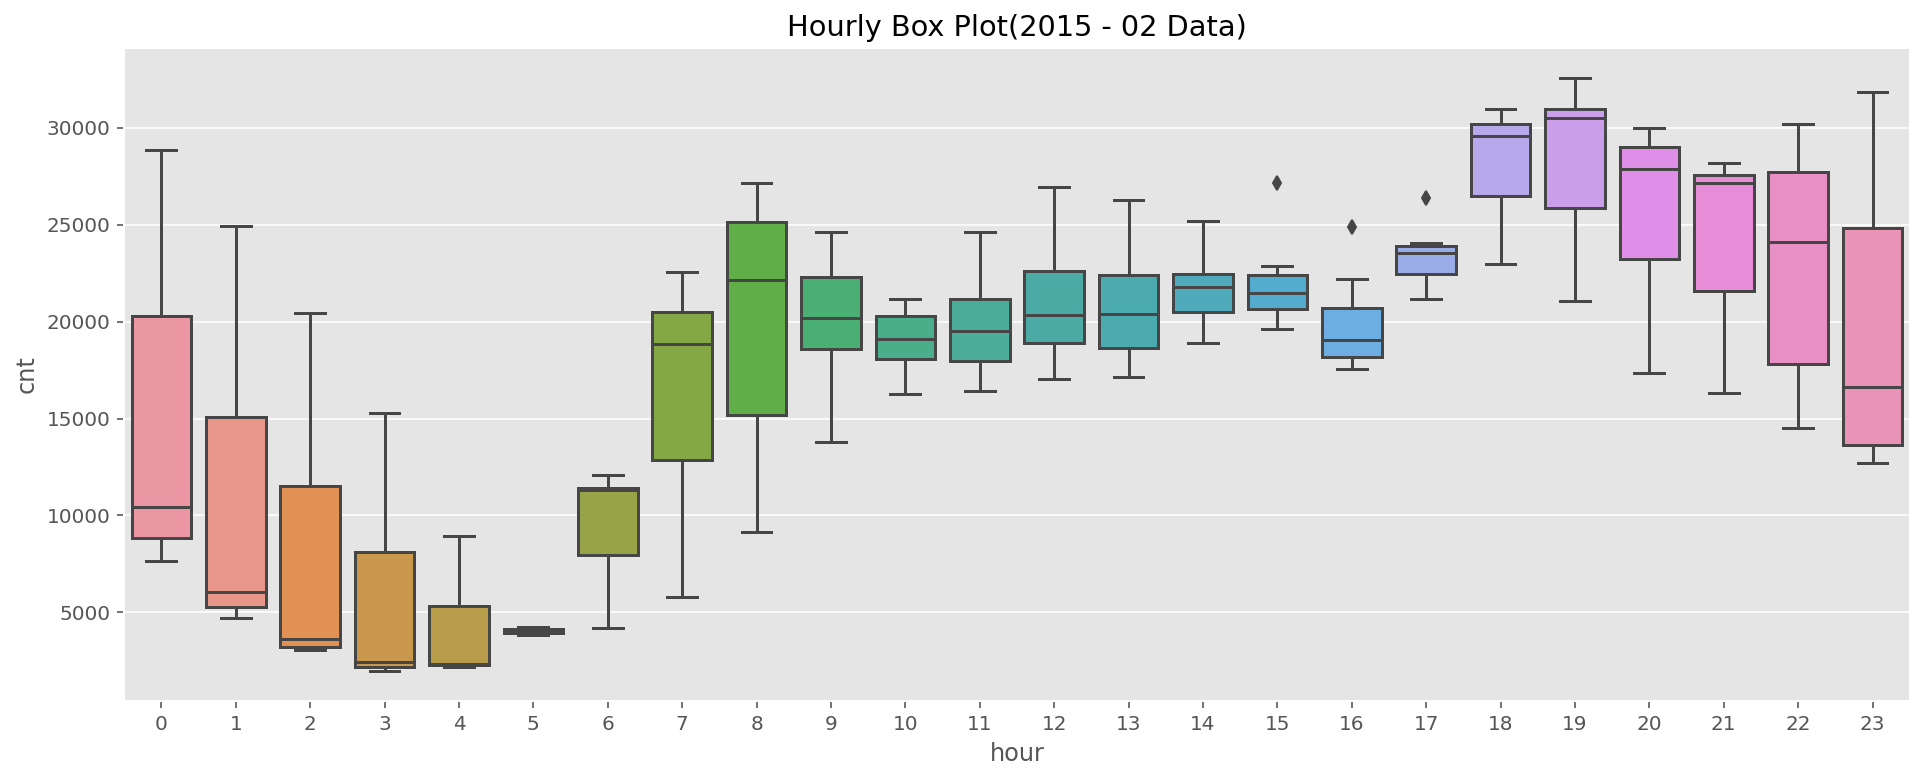

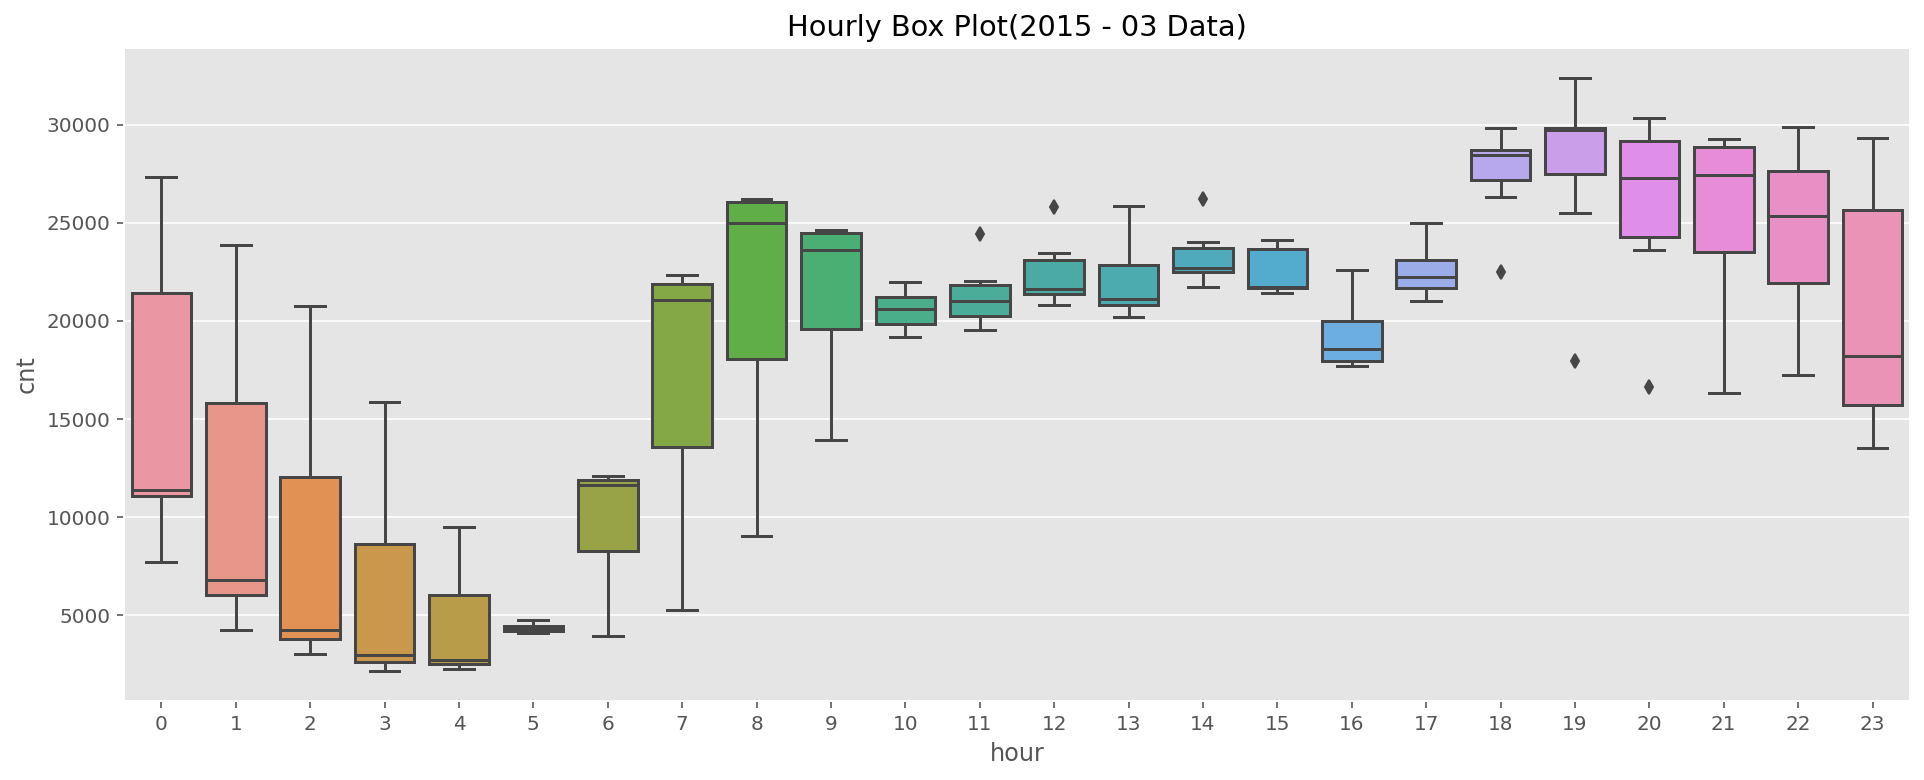

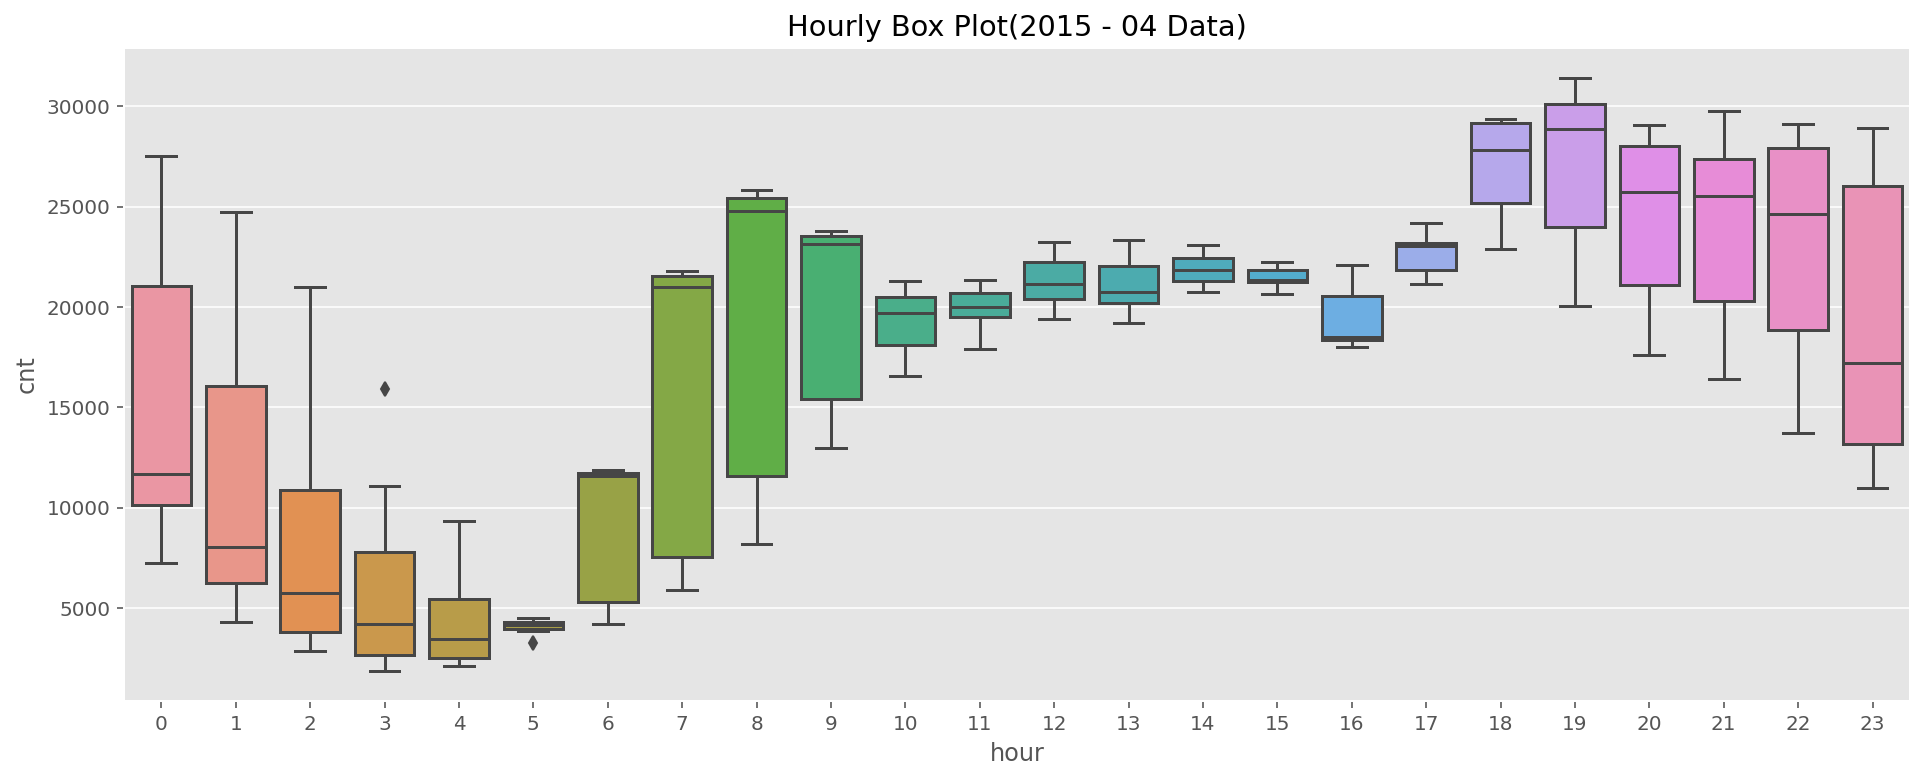

In [46]:
for week in range(1, 5):
    visualize_hourly_boxplot_by_weeknum(df, 'cnt', week)

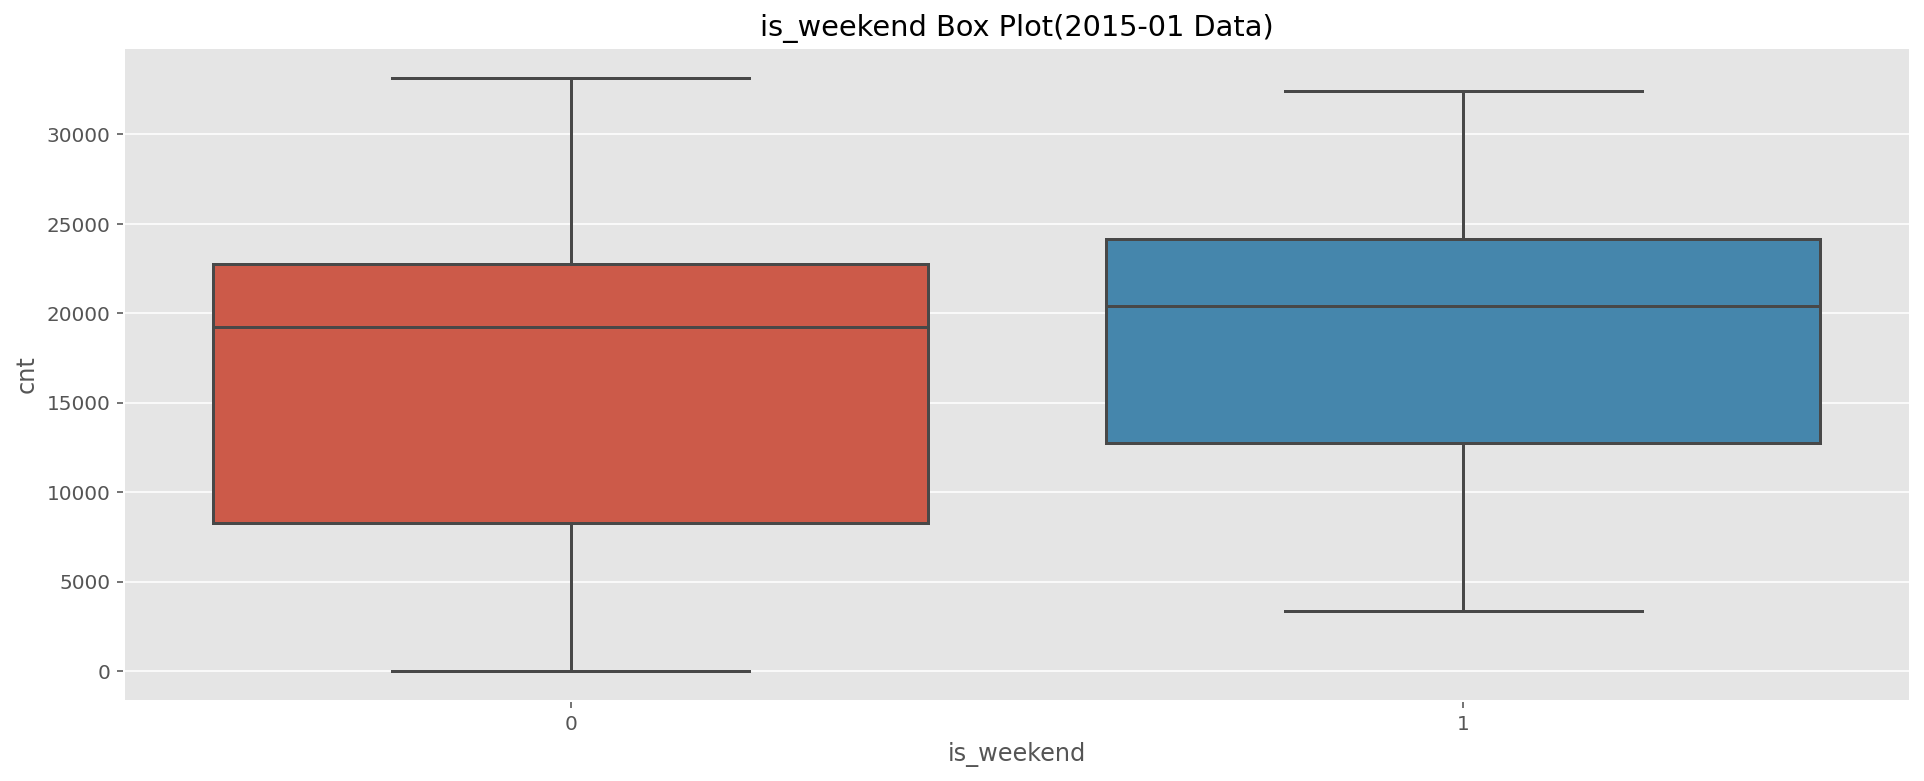

In [47]:
plt.figure(figsize=(16, 6));
sns.boxplot(x='is_weekend', y='cnt', data=df);
plt.title('is_weekend Box Plot(2015-01 Data)');

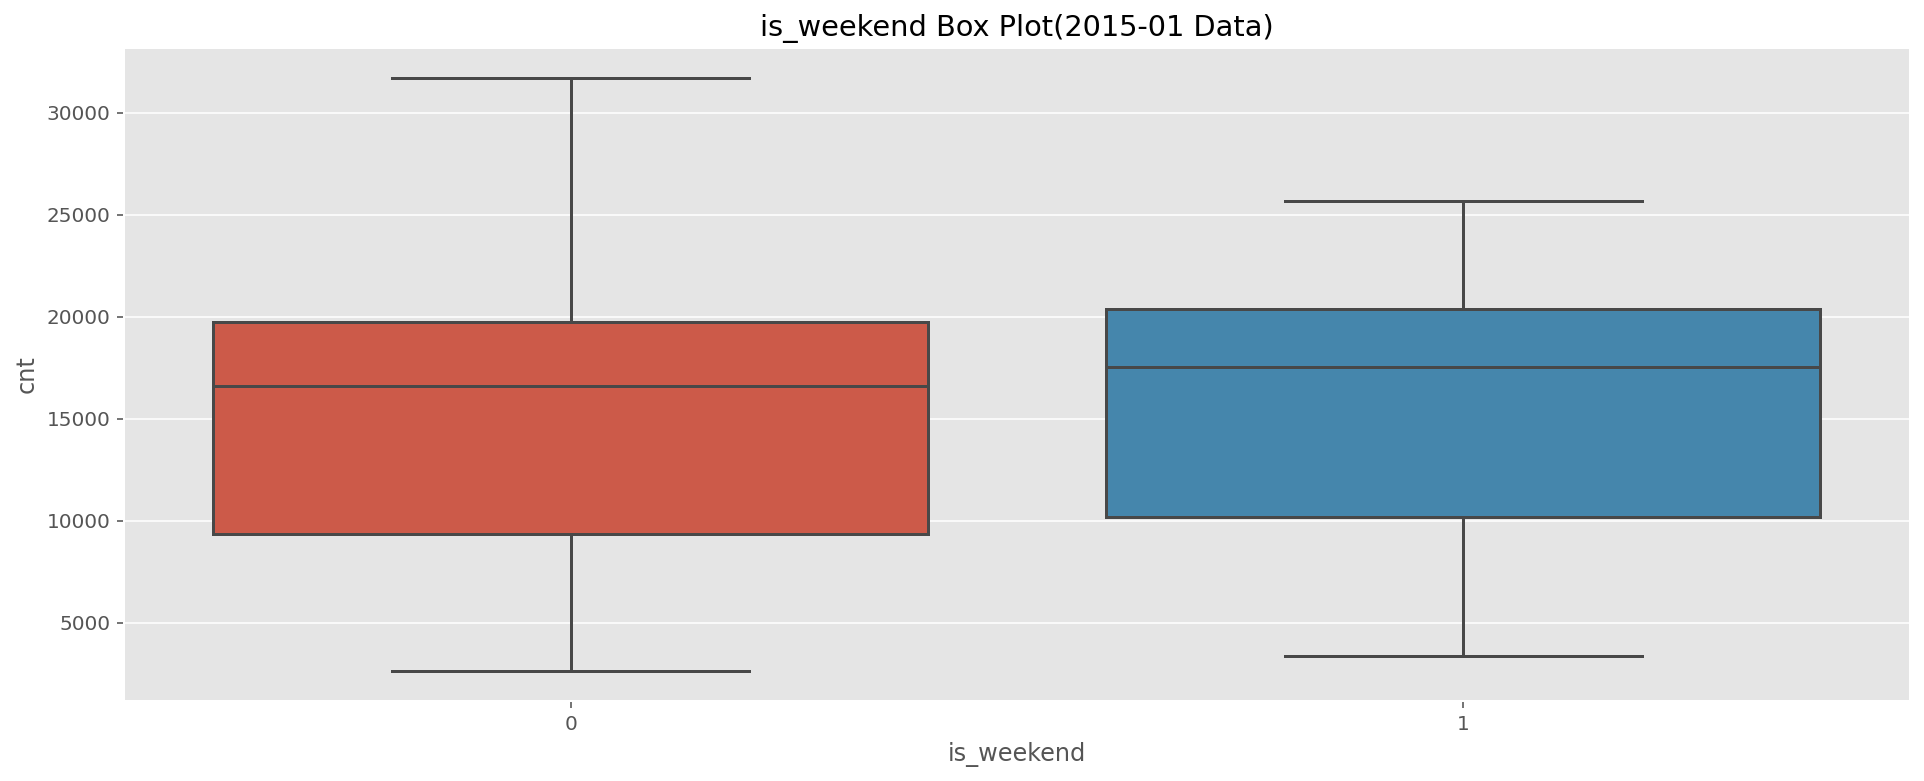

In [48]:
plt.figure(figsize=(16, 6));
sns.boxplot(x='is_weekend', y='cnt', data=df[df['weeknum']==1]);
plt.title('is_weekend Box Plot(2015-01 Data)');

### Violin Plot

In [49]:
weekday_dict = {
    0:'Monday',
    1:'Tuesday',
    2:'Wednesday',
    3:'Thursday',
    4:'Friday',
    5:'Saturday',
    6:'Sunday'
}

In [51]:
def visualize_violinplot_by_weekday(df, y, weekday):
    plt.figure(figsize=(16, 6));
    sns.violinplot(x='hour', y=y, hue='weekday',
                  data=df[df['weekday'] == weekday][['hour', 'weekday', y]],
                  inner='quart');
    plt.title(f"{weekday_dict[weekday]}'s hourly violinplot {y}(2015-01 Data)")

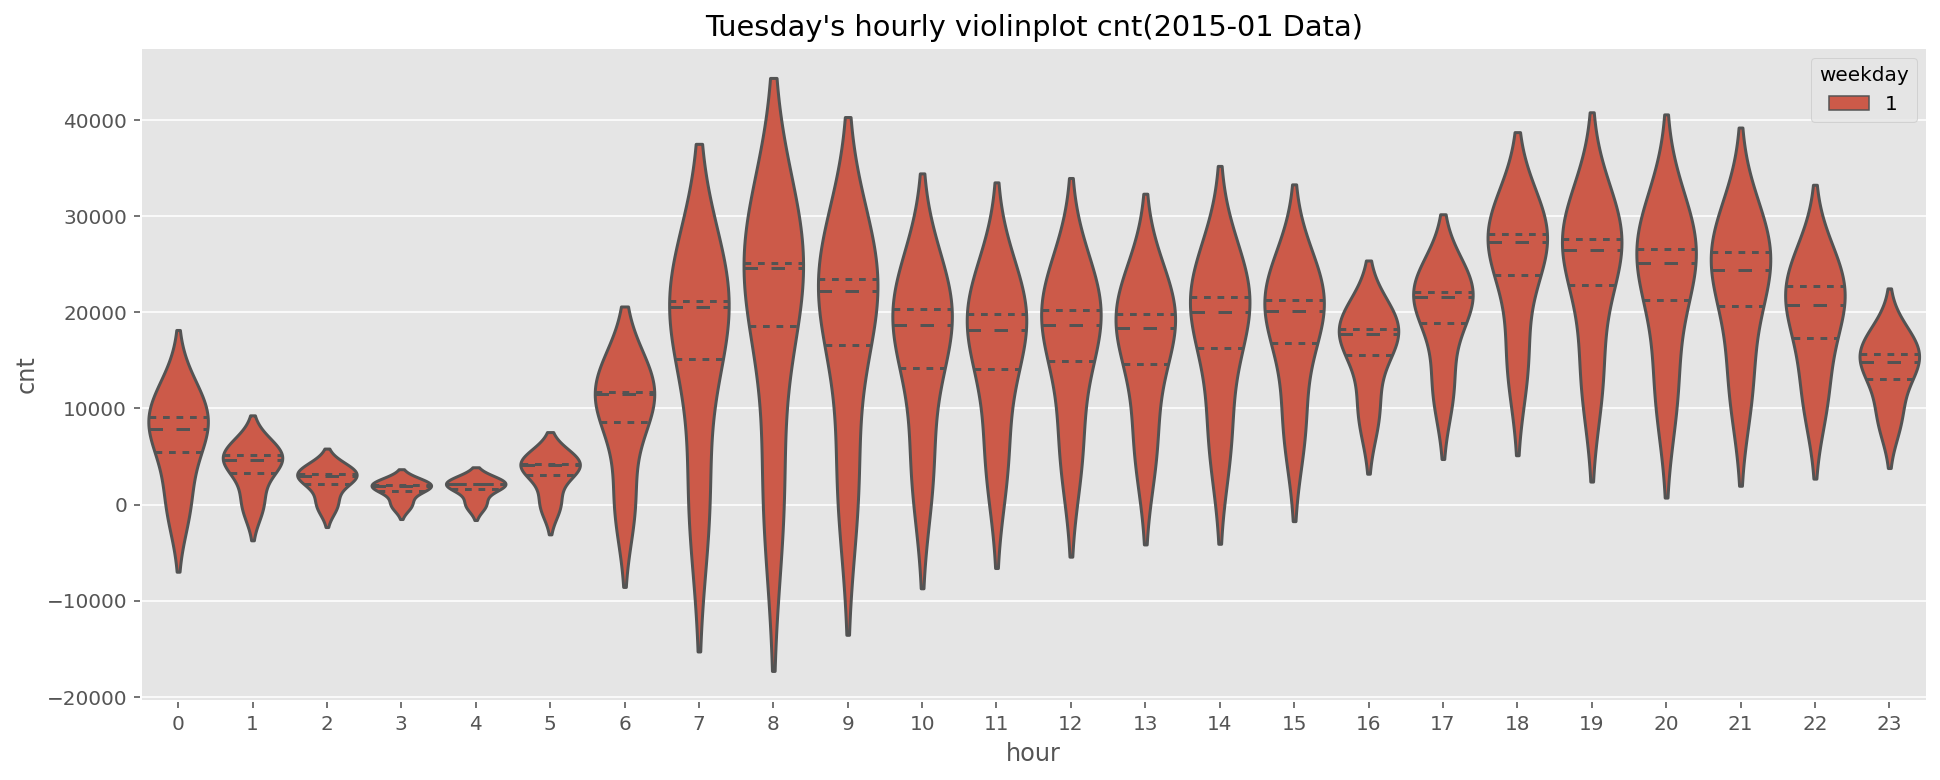

In [52]:
visualize_violinplot_by_weekday(df, 'cnt', 1)

- 월요일부터 토요일까지의 승객 수를 violin plot으로 표시

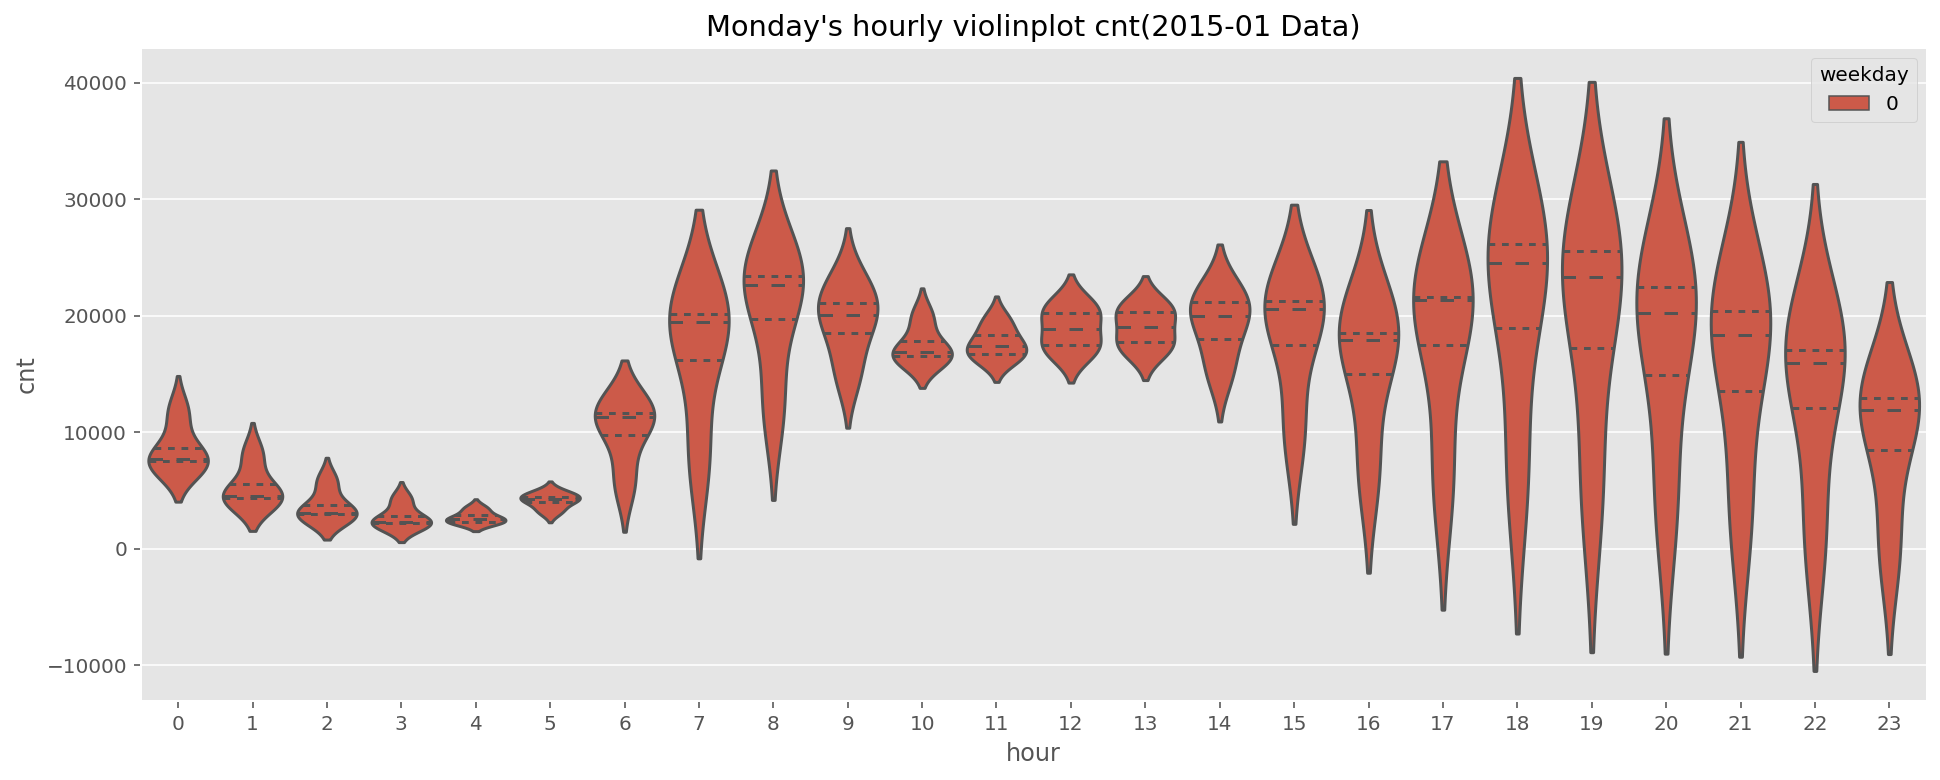

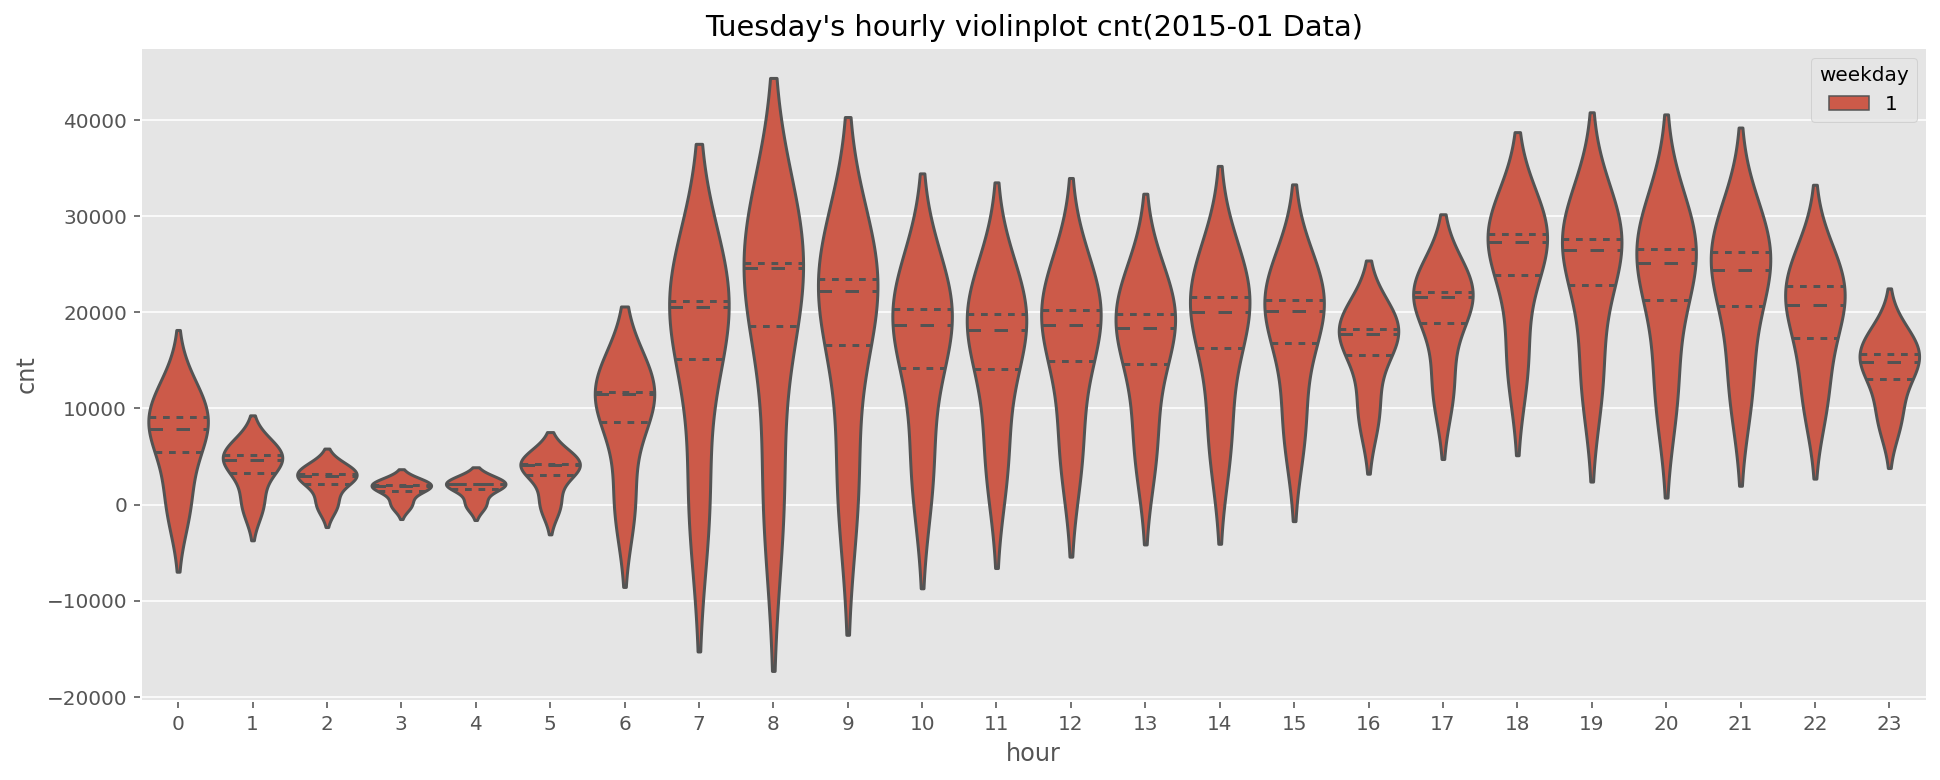

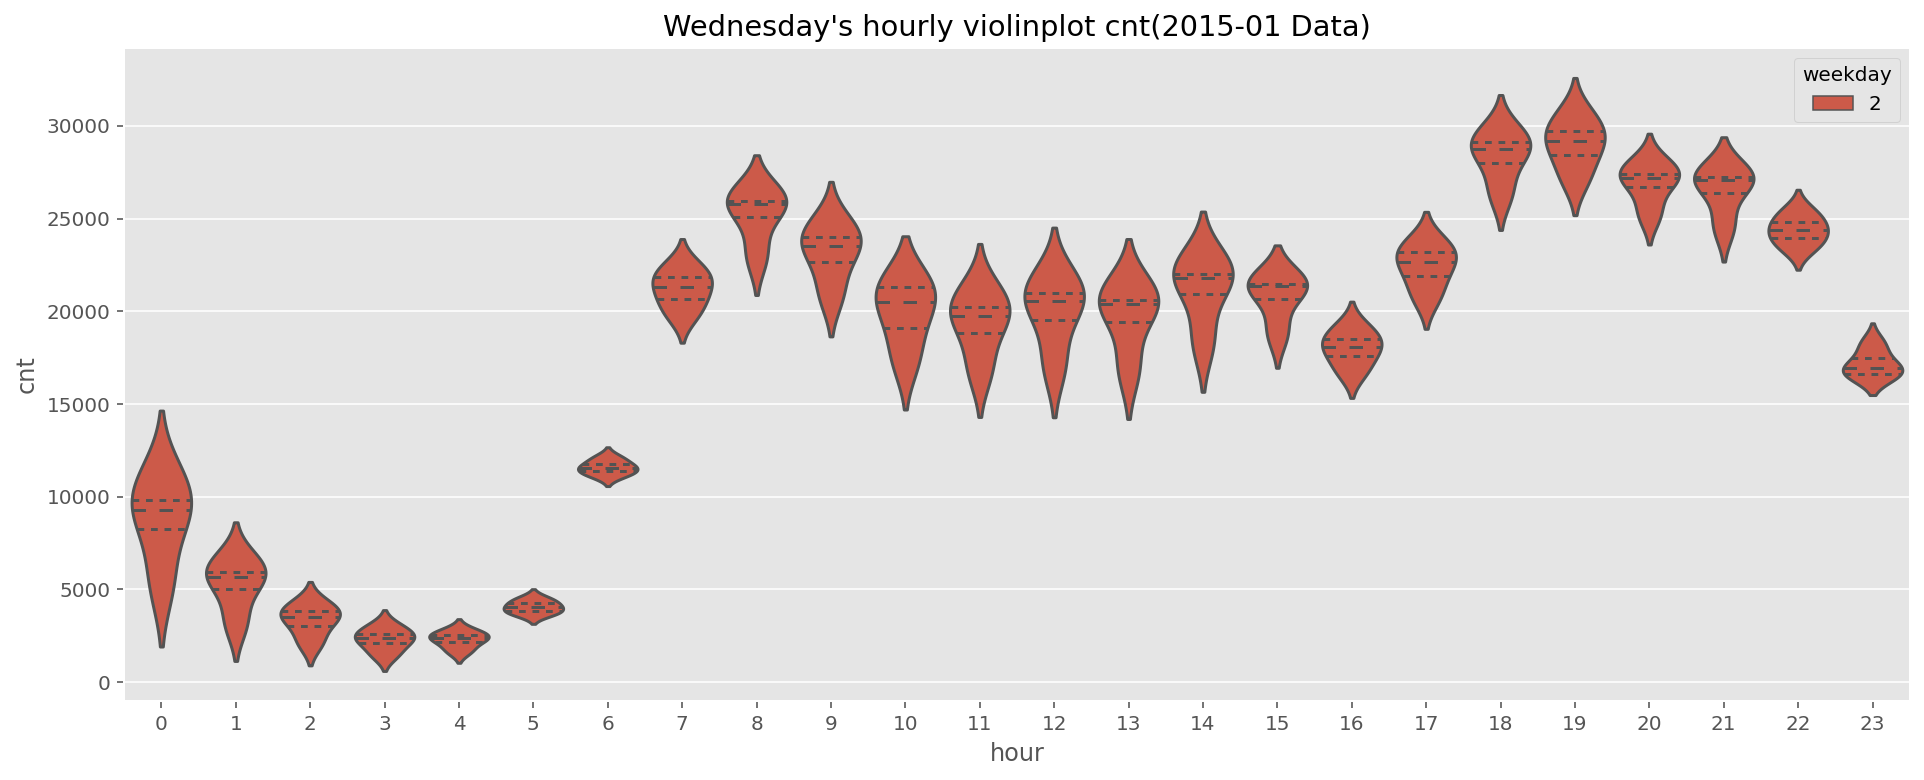

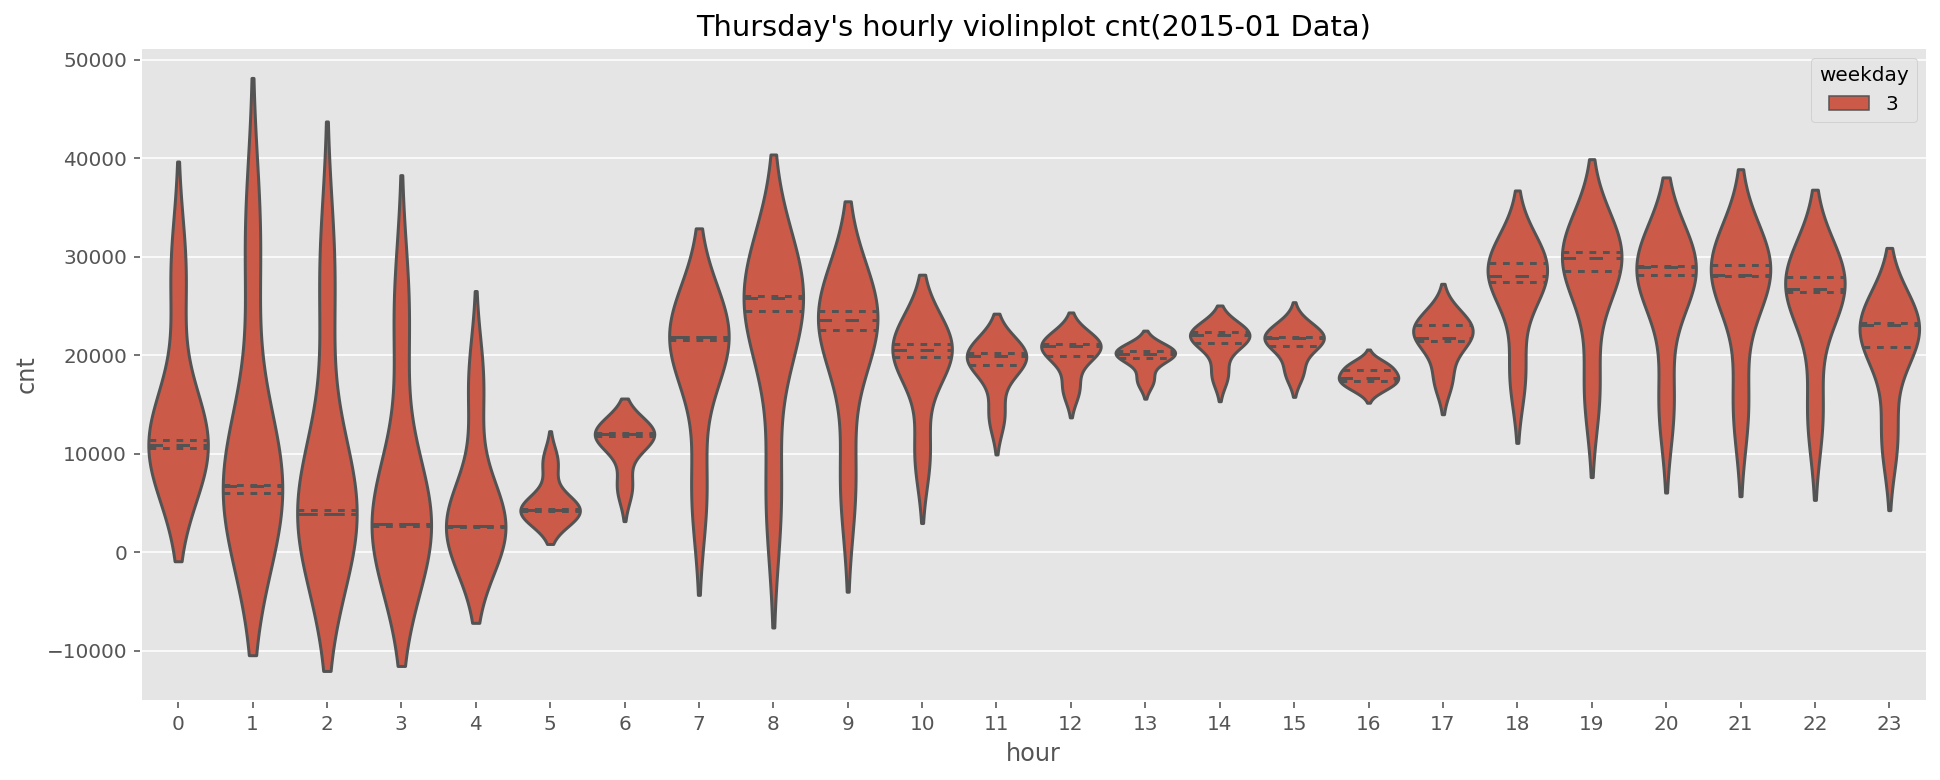

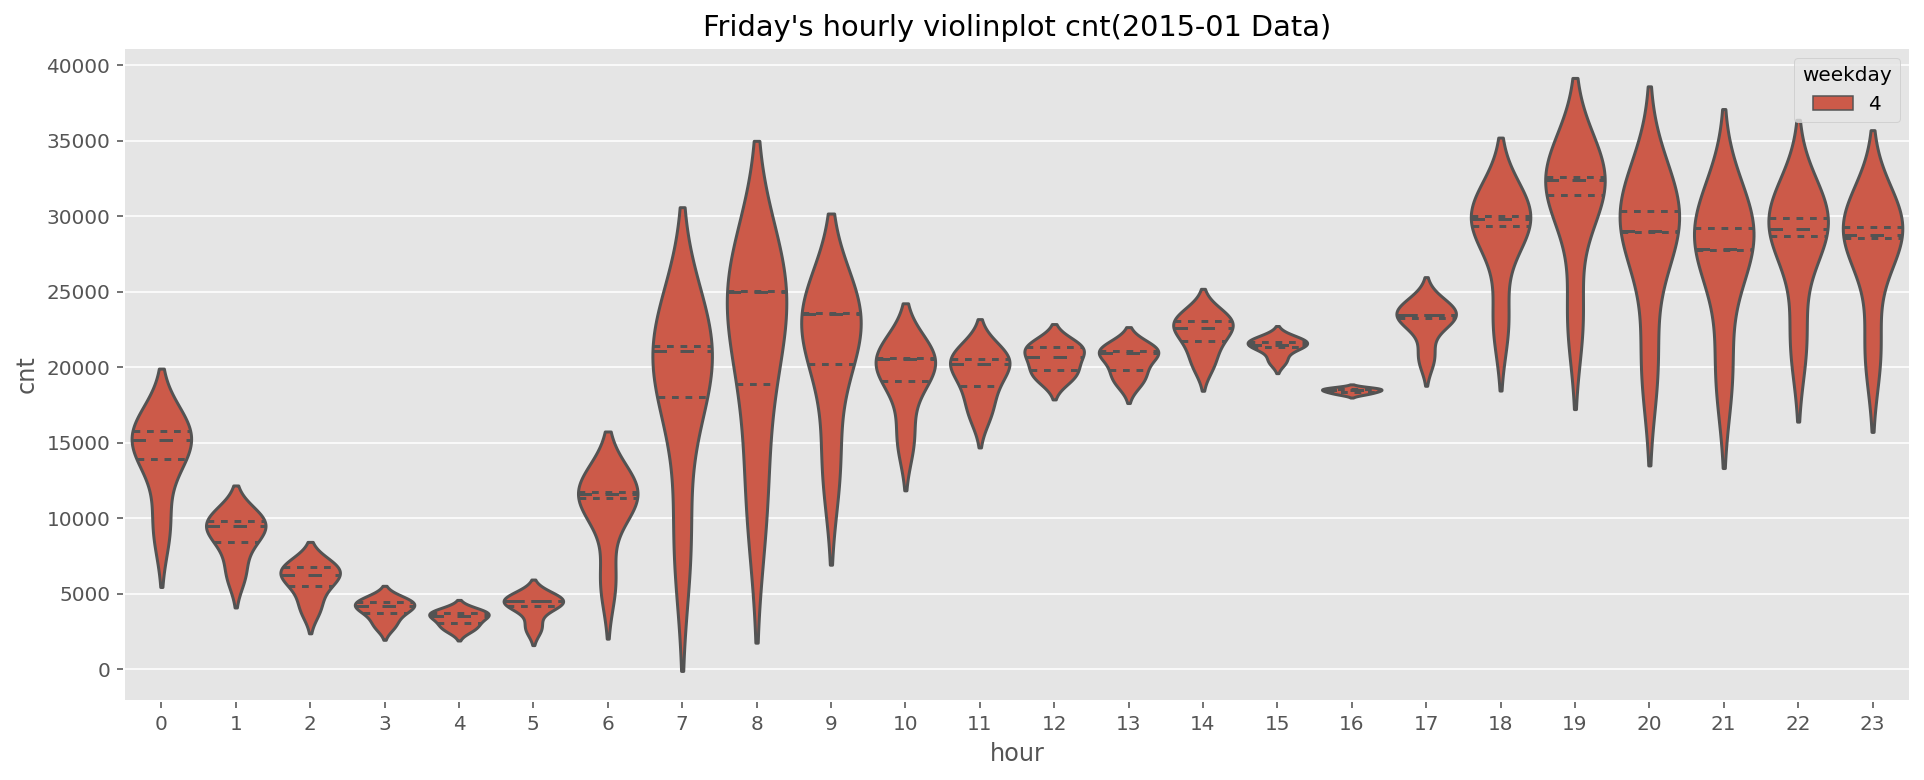

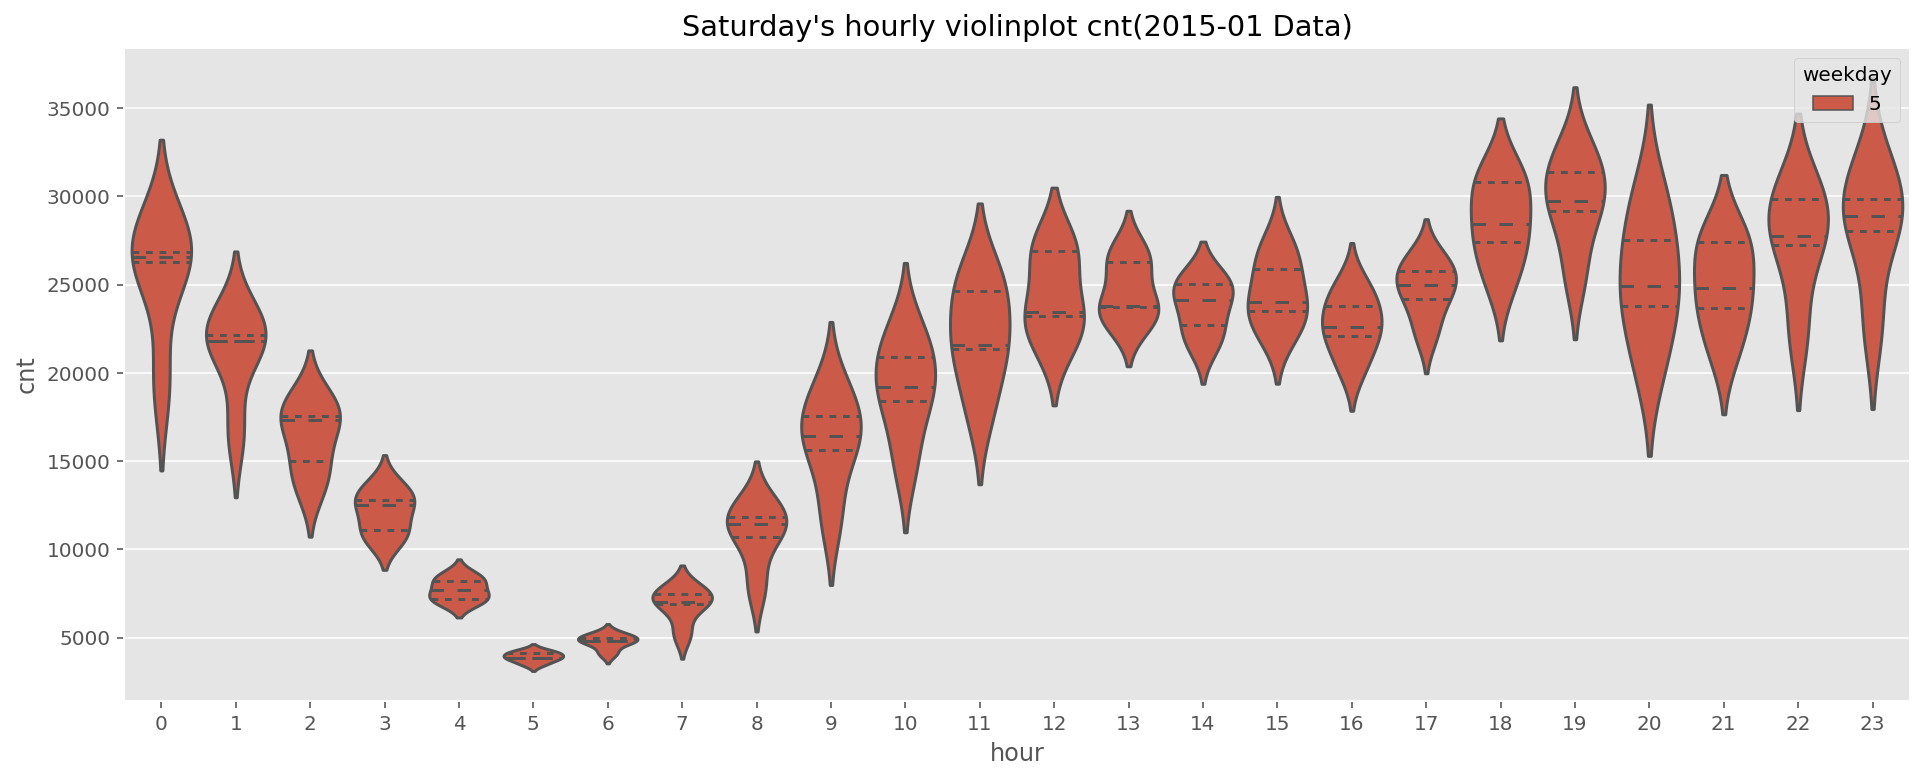

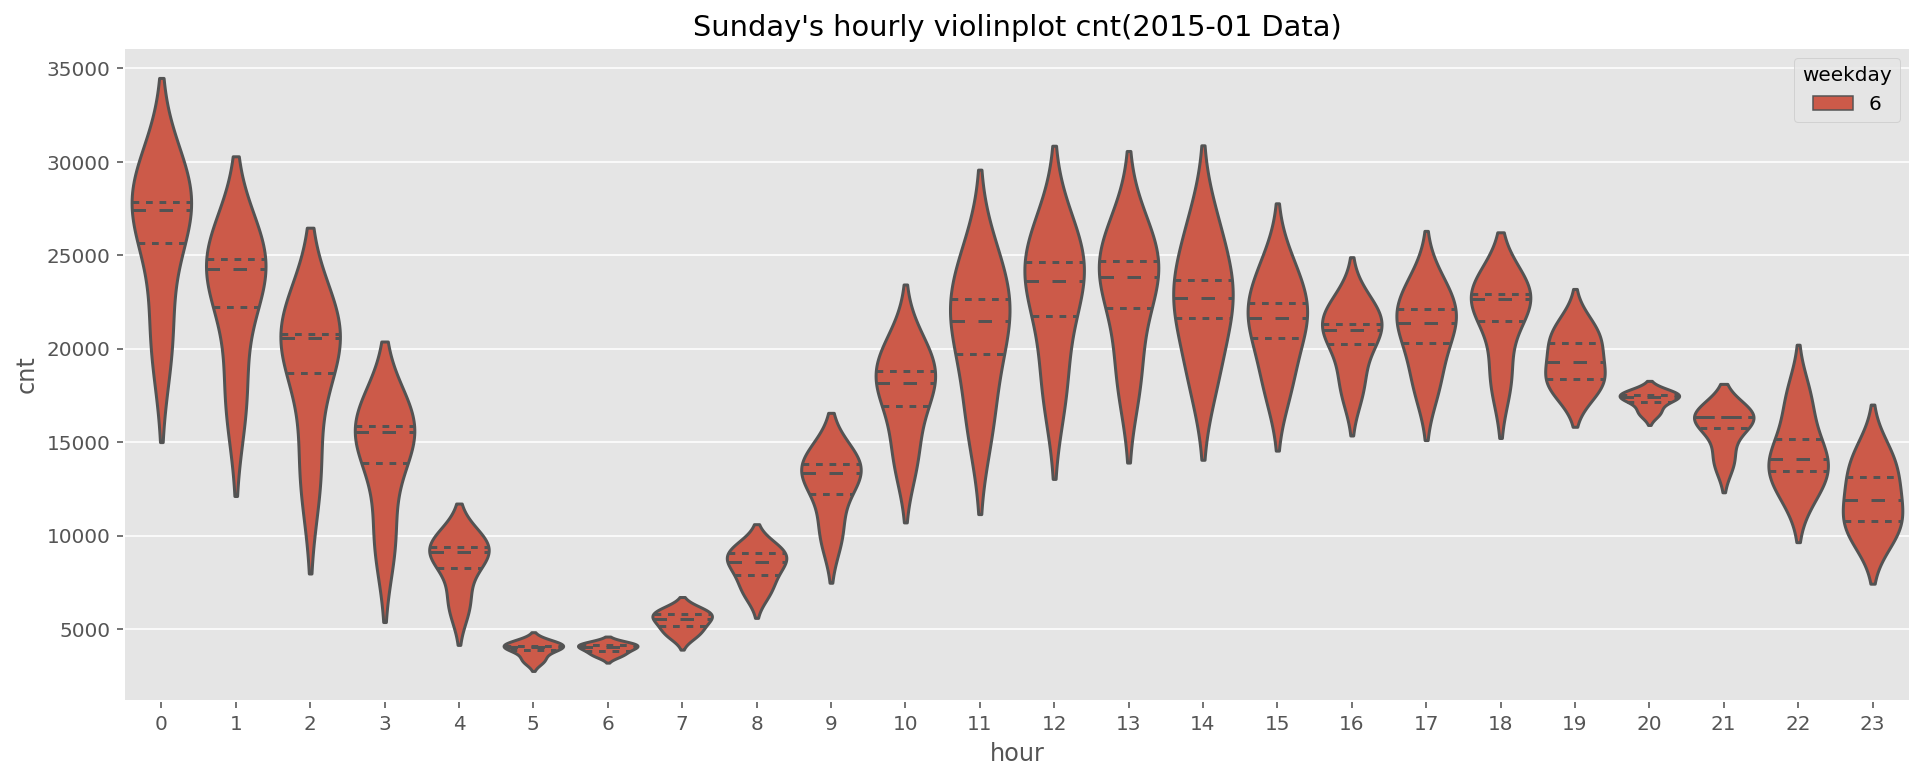

In [53]:
for weekday in range(0, 7):
    visualize_violinplot_by_weekday(df, 'cnt', weekday)

### trip_distance 분포

In [58]:
%%time

trip_distance_query = """
SELECT
    floor(trip_distance/30)*30 as bucket_floor,
    count(*) as count
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
WHERE EXTRACT(MONTH from pickup_datetime) = 1
GROUP BY bucket_floor
order by bucket_floor
"""

trip_distance_query_log = """
SELECT
    floor(trip_distance/30)*30 as bucket_floor,
    log10(count(*)) as count
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
WHERE EXTRACT(MONTH from pickup_datetime) = 1
GROUP BY bucket_floor
order by bucket_floor
"""

distance_df = pd.read_gbq(query=trip_distance_query, dialect='standard', project_id='predictfornyctaxi')
distance_log_df = pd.read_gbq(query=trip_distance_query_log, dialect='standard', project_id='predictfornyctaxi')

CPU times: user 187 ms, sys: 17 ms, total: 204 ms
Wall time: 8.69 s


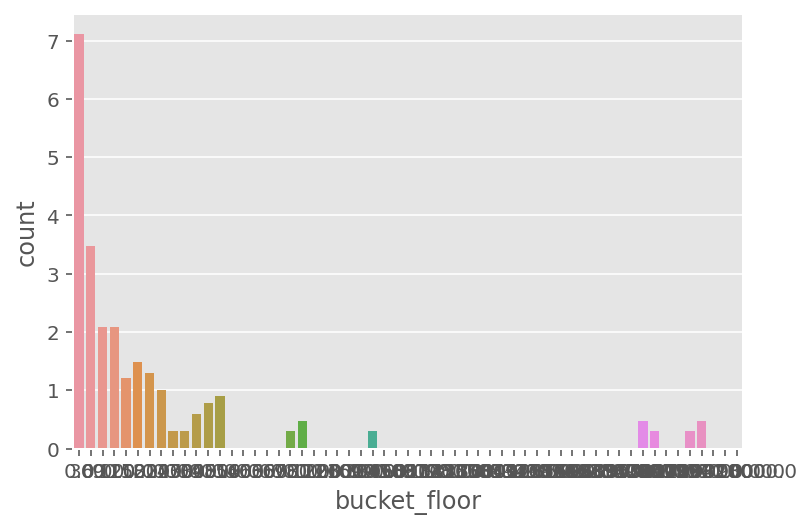

In [62]:
sns.barplot(x=distance_log_df['bucket_floor'], y=distance_log_df['count']);

In [60]:
distance_df.head(5)

bucket_floor     count
0           0.0  12745563
1          30.0      3027
2          60.0       120
3          90.0       124
4         120.0        16

### 장거리 / 단거리 수요
- 시간대별 장거리/단거리 수요

In [67]:
%%time

short_trip_query = """
SELECT
    EXTRACT(HOUR FROM pickup_datetime) as pickup_hour,
    EXTRACT(HOUR FROM dropoff_datetime) as dropoff_hour,
    count(*) as count
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
WHERE EXTRACT(MONTH from pickup_datetime) = 1
and trip_distance < 30
GROUP BY pickup_hour, dropoff_hour
"""

short_trip_df = pd.read_gbq(query=short_trip_query, dialect='standard', project_id='predictfornyctaxi')

CPU times: user 75.9 ms, sys: 7.14 ms, total: 83.1 ms
Wall time: 2.76 s


In [68]:
%%time

long_trip_query = """
SELECT
    EXTRACT(HOUR FROM pickup_datetime) as pickup_hour,
    EXTRACT(HOUR FROM dropoff_datetime) as dropoff_hour,
    count(*) as count
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
WHERE EXTRACT(MONTH from pickup_datetime) = 1
and trip_distance >= 30
GROUP BY pickup_hour, dropoff_hour
"""

long_trip_df = pd.read_gbq(query=long_trip_query, dialect='standard', project_id='predictfornyctaxi')

CPU times: user 85.1 ms, sys: 7.62 ms, total: 92.7 ms
Wall time: 2.65 s


In [69]:
short_trip_df.head(5)

pickup_hour  dropoff_hour   count
0           17            17  513568
1           17            18  154322
2            8             8  435904
3           14            14  511868
4           15            15  510697

In [70]:
long_trip_df.head(5)

pickup_hour  dropoff_hour  count
0           14            15    137
1            6             8     13
2            5             6     53
3           19            20    104
4           16            16     27

In [71]:
trip_df = short_trip_df.merge(long_trip_df, on=['pickup_hour', 'dropoff_hour'], suffixes=['_short', '_long']) \
.rename(columns={'count_short':'short_trips', 'count_long': 'long_trips'})

In [72]:
trip_df_pickup = trip_df.groupby(['pickup_hour'], as_index=False).agg({'short_trips':'sum', 'long_trips':'sum'}) \
.sort_values(by='pickup_hour')

trip_df_dropoff= trip_df.groupby(['dropoff_hour'], as_index=False).agg({'short_trips':'sum', 'long_trips':'sum'}) \
.sort_values(by='dropoff_hour')

In [74]:
trip_df_pickup.head(5)

pickup_hour  short_trips  long_trips
0            0       469713         146
1            1       354890          94
2            2       267918          89
3            3       198414          59
4            4       143109          62

In [75]:
trip_df_dropoff.head(5)

dropoff_hour  short_trips  long_trips
0             0       494882         149
1             1       377049         147
2             2       284456         100
3             3       208594          81
4             4       156581          57

### 시계 그림으로 장/단거리 수요 표현하기

In [76]:
def plt_clock(ax, radii, title, color):
    N = 24
    bottom = 2
    
    # 24시간을 위한 theta 생성
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    
    # plot의 각각의 bin width 지정
    width = 2*np.pi / N
    
    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=color, edgecolor='#999999')
    
    # label을 시계 방향으로 설정하고 위에서 시작
    ax.set_theta_zero_location('N')
    
    # 시계 방향 설정
    ax.set_theta_direction(-1)
    
    # label 설정
    ax.set_xticks(theta)
    ticks = ["{}:00".format(x) for x in range(24)]
    ax.set_xticklabels(ticks)
    ax.set_title(title)

In [80]:
def diff_short_long_trip_on_time(trip_df_pickup, trip_df_dropoff):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
    
    # 2, 2의 첫 번째에 그림
    ax = plt.subplot(2, 2, 1, polar=True)
    # 24시간의 각각의 bin에 히스토그램 그림
    radii = np.array(trip_df_pickup['short_trips'].tolist(), dtype='int64')
    title = 'Pickup Time for Short Trips'
    plt_clock(ax, radii, title, "#dc143c")
    
    # 2, 2의 첫 번째에 그림
    ax = plt.subplot(2, 2, 2, polar=True)
    # 24시간의 각각의 bin에 히스토그램 그림
    radii = np.array(trip_df_pickup['long_trips'].tolist(), dtype='int64')
    title = 'Pickup Time for Long Trips'
    plt_clock(ax, radii, title, "#56B4E9")
    
    ax = plt.subplot(2, 2, 3, polar=True)
    radii = np.array(trip_df_dropoff['short_trips'].tolist(), dtype='int64')
    title = 'Dropoff Time for Short Trips'
    plt_clock(ax, radii, title, "#dc143c")
    
    ax = plt.subplot(2, 2, 4, polar=True)
    # 24시간의 각각의 bin에 히스토그램 그림
    radii = np.array(trip_df_dropoff['long_trips'].tolist(), dtype='int64')
    title = 'Dropoff Time for Long Trips'
    plt_clock(ax, radii, title, "#56B4E9")

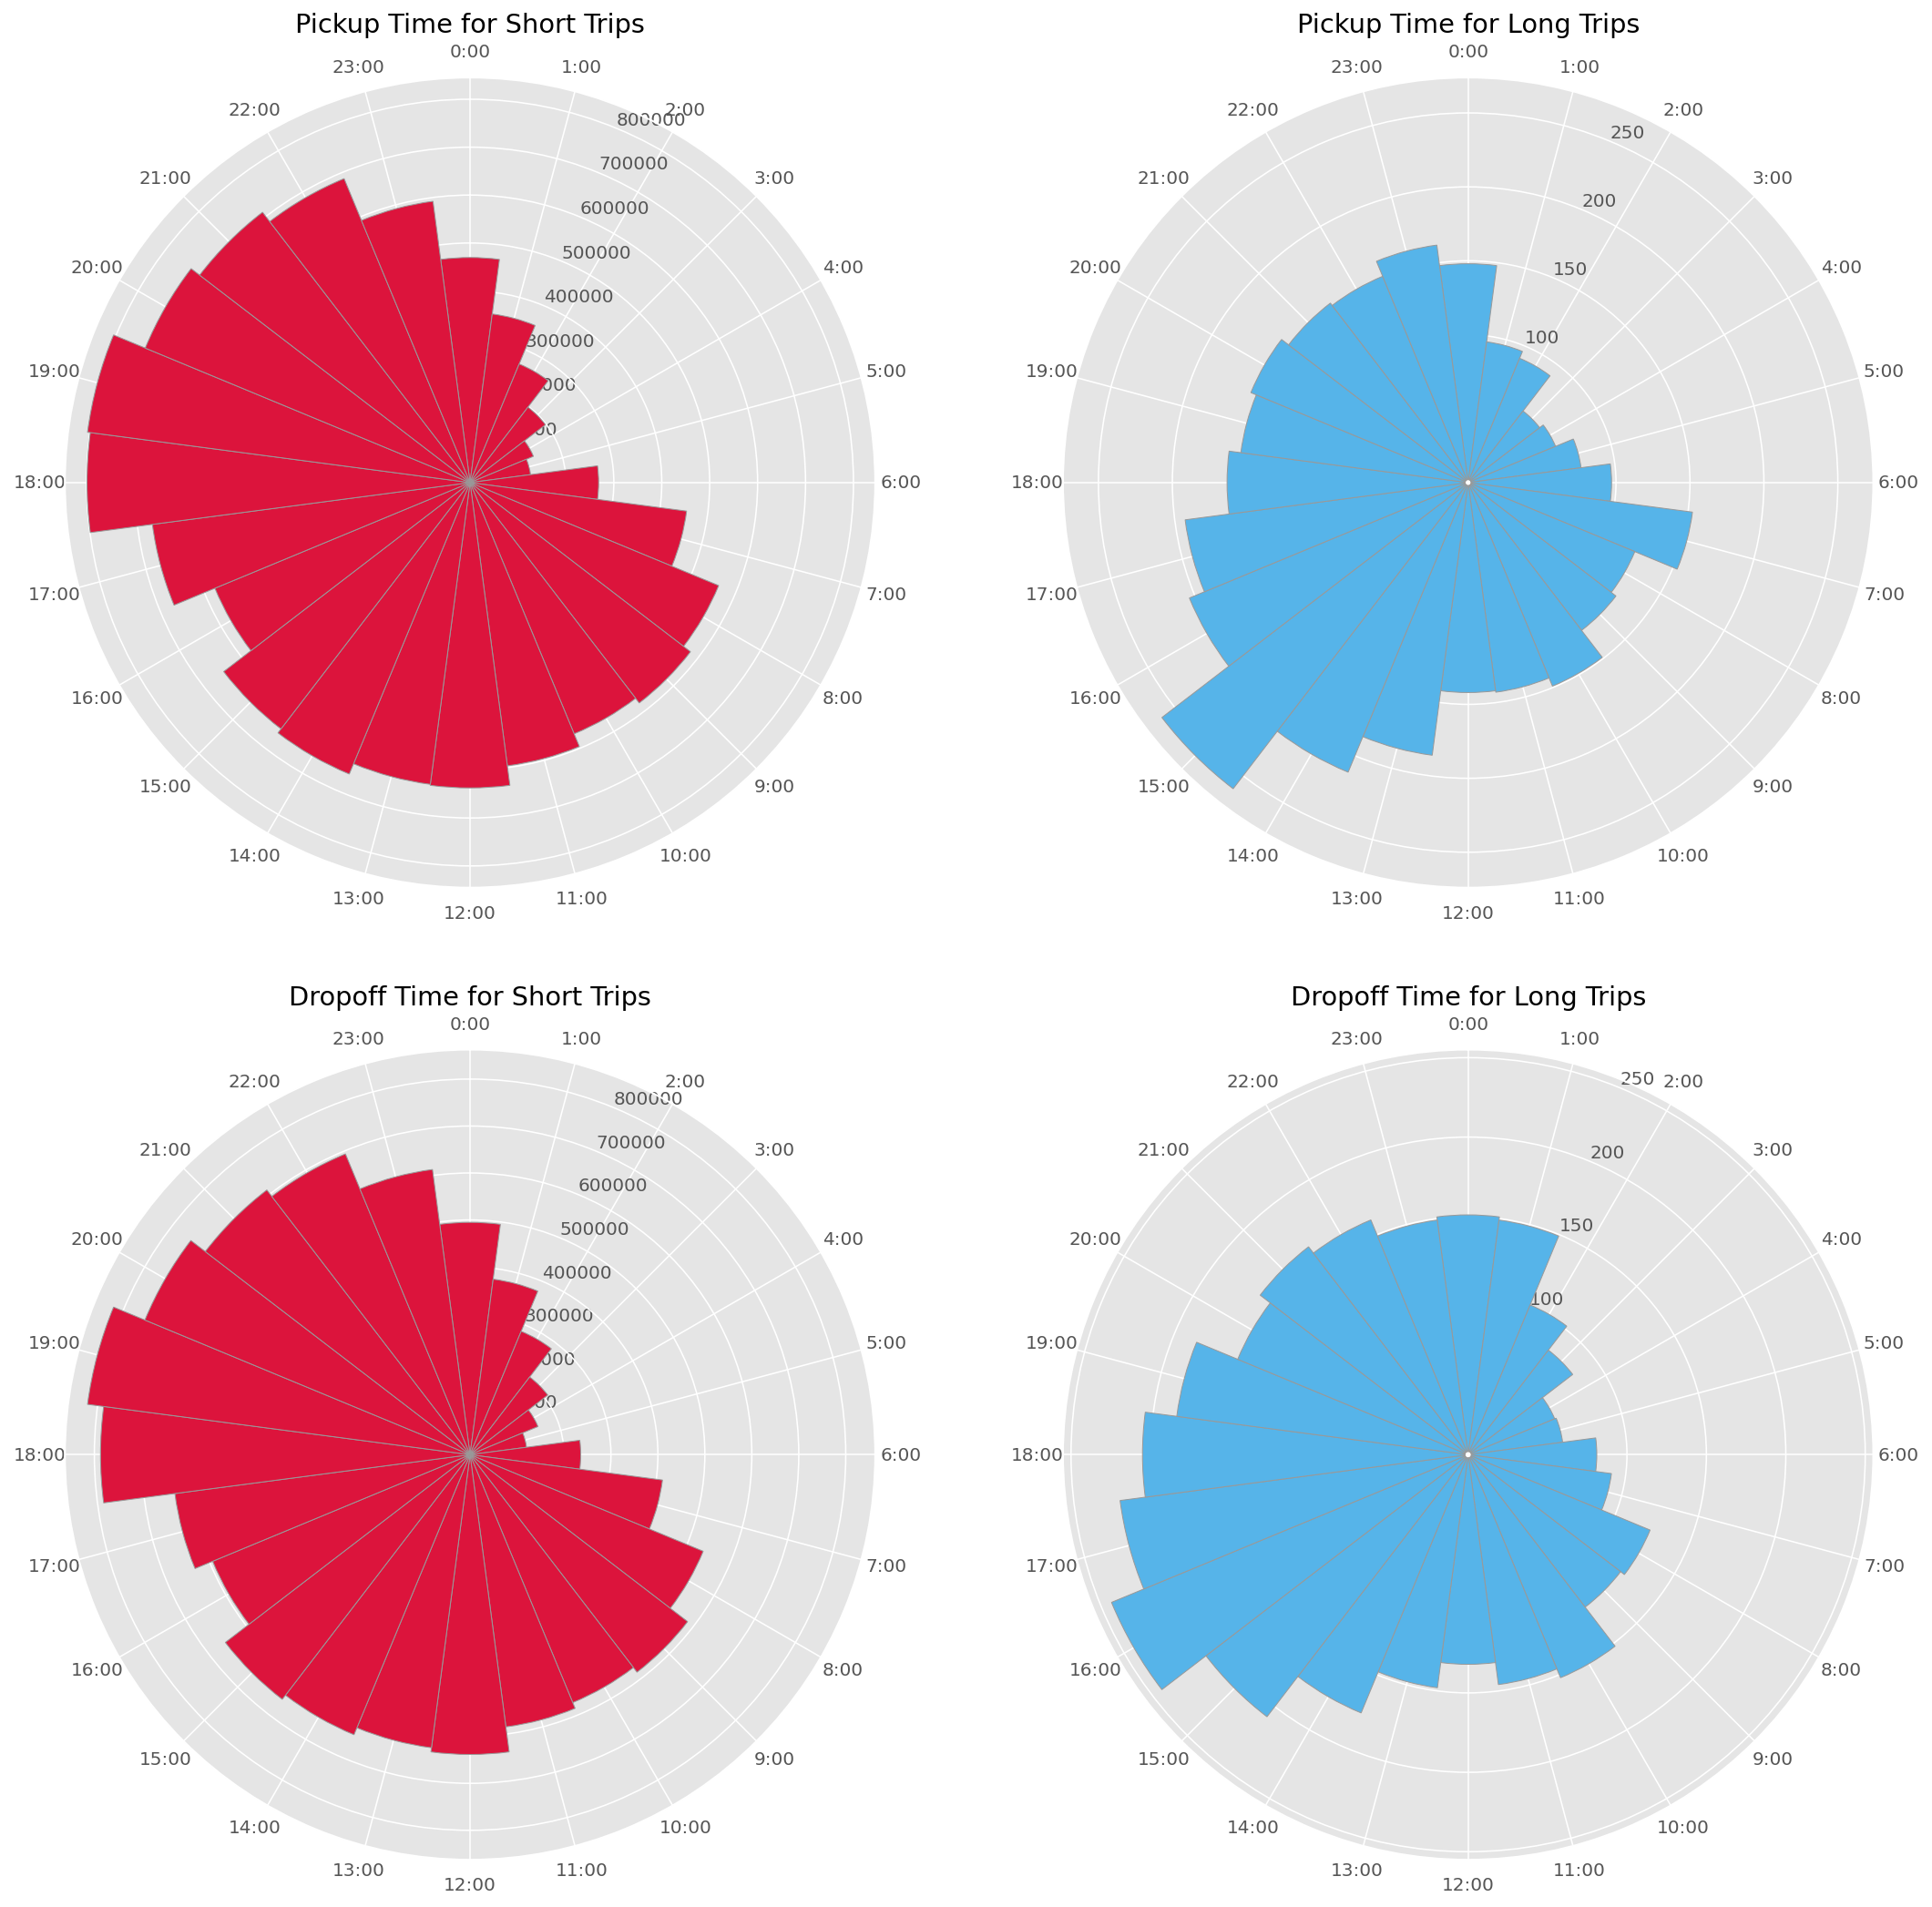

In [81]:
diff_short_long_trip_on_time(trip_df_pickup, trip_df_dropoff)

- 피크 타임
    - Short trip
        - 18:00 ~ 22:00
    - Long trip
        - 13:00 ~ 15:30